# import stuff

In [1]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import glob
import netCDF4
import pandas
import wrf
import string
import seaborn
import matplotlib.colors
import cmocean
import matplotlib.cm

import metpy
import metpy.plots
import metpy.calc
import metpy.units

import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

% matplotlib inline

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function w

# set up wet and dry regions

In [2]:
dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -60,-50,-10,10
wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-75,-10,10

dry_lon_lo_degE = 360+dry_lon_lo
dry_lon_hi_degE = 360+dry_lon_hi

wet_lon_lo_degE = 360+wet_lon_lo
wet_lon_hi_degE = 360+wet_lon_hi

In [3]:
lon_lo_ama = dry_lon_lo
lon_hi_ama = dry_lon_hi
lat_lo_ama = dry_lat_lo
lat_hi_ama = dry_lat_hi

lon_lo_and = wet_lon_lo
lon_hi_and = wet_lon_hi
lat_lo_and = wet_lat_lo
lat_hi_and = wet_lat_hi

# open control data

In [4]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [5]:
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [6]:
rainc_400 = cont_mfds['RAINC'].values
rainnc_400 = cont_mfds['RAINNC'].values

In [7]:
time = cont_mfds['Times'].values
xlat = cont_mfds['XLAT'].values[0,:,:]
xlong = cont_mfds['XLONG'].values[0,:,:]
landmask = cont_mfds['LANDMASK'].values[0,:,:]
landmask_midpoints = landmask[1:,1:]

In [8]:
hgt = cont_mfds['HGT'].sel(Time=0).values

# get time info

In [9]:
time_datetimes = pandas.to_datetime([i.decode('utf-8') for i in time], format = '%Y-%m-%d_%H:%M:%S')

In [10]:
time_datetimes_shifted_ama = time_datetimes + datetime.timedelta(hours=-4)
time_datetimes_shifted_and = time_datetimes + datetime.timedelta(hours=-5)

# get land mask info

In [11]:
landmask_indices = numpy.copy(landmask)
landmask_indices[landmask==1]=1
landmask_indices[landmask!=1]=0
landmask_indices = numpy.array(landmask_indices, dtype=bool)

In [12]:
lon_indices_ama = (xlong>=lon_lo_ama)&(xlong<=lon_hi_ama)
lat_indices_ama = (xlat>=lat_lo_ama)&(xlat<=lat_hi_ama)
latlon_indices_ama = (lon_indices_ama)&(lat_indices_ama)&(landmask_indices)

In [13]:
lon_indices_and = (xlong>=lon_lo_and)&(xlong<=lon_hi_and)
lat_indices_and = (xlat>=lat_lo_and)&(xlat<=lat_hi_and)
latlon_indices_and = (lon_indices_and)&(lat_indices_and)&(landmask_indices)

In [14]:
latlon_indices_and_high = (lon_indices_and)&(lat_indices_and)&(landmask_indices)&(hgt>1500.)

# open phys data

In [15]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [16]:
rainc_1000 = phys_mfds['RAINC'].values
rainnc_1000 = phys_mfds['RAINNC'].values

# rain diffs for hourly

In [17]:
raintot_400 = rainc_400+rainnc_400
raintot_1000 = rainc_1000+rainnc_1000

In [18]:
raintot_diffs_400 = numpy.zeros((raintot_400.shape))*numpy.nan
raintot_diffs_1000 = numpy.zeros((raintot_1000.shape))*numpy.nan

raintot_diffs_400[:-1,:,:] = numpy.diff(raintot_400, axis=0)
raintot_diffs_1000[:-1,:,:] = numpy.diff(raintot_1000, axis=0)

# raintot diffs

In [19]:
raintot_diffs_400_latlon_subset_ama = raintot_diffs_400[:,latlon_indices_ama]
raintot_diffs_1000_latlon_subset_ama = raintot_diffs_1000[:,latlon_indices_ama]

raintot_diffs_400_latlon_mean_ama = numpy.nanmean(raintot_diffs_400_latlon_subset_ama, axis=1)
raintot_diffs_1000_latlon_mean_ama = numpy.nanmean(raintot_diffs_1000_latlon_subset_ama, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [62]:
raintot_diffs_400_latlon_subset_and = raintot_diffs_400[:,latlon_indices_and]
raintot_diffs_1000_latlon_subset_and = raintot_diffs_1000[:,latlon_indices_and]

raintot_diffs_400_latlon_mean_and = numpy.nanmean(raintot_diffs_400_latlon_subset_and, axis=1)
raintot_diffs_1000_latlon_mean_and = numpy.nanmean(raintot_diffs_1000_latlon_subset_and, axis=1)

raintot_diffs_400_latlon_subset_and_high = raintot_diffs_400[:,latlon_indices_and_high]
raintot_diffs_1000_latlon_subset_and_high = raintot_diffs_1000[:,latlon_indices_and_high]

raintot_diffs_400_latlon_mean_and_high = numpy.nanmean(raintot_diffs_400_latlon_subset_and_high, axis=1)
raintot_diffs_1000_latlon_mean_and_high = numpy.nanmean(raintot_diffs_1000_latlon_subset_and_high, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


# time periods:
* Amazon:  8am to 8pm (AMtoPM) - daytime
* Amazon:  8pm to 8am (PMtoAM) - overnight

* Andes:  10am to 6pm (AMtoPM) - daytime
* Andes:  6pm to 10am (PMtoAM) - overnight

In [20]:
time_indices_AMtoPM_ama = [t.hour in range(8,20) for t in time_datetimes_shifted_ama]
time_indices_PMtoAM_ama = [(t.hour in range(20,24)) or (t.hour in range(0,8)) for t in time_datetimes_shifted_ama]

time_indices_AMtoPM_and = [t.hour in range(10,18) for t in time_datetimes_shifted_and]
time_indices_PMtoAM_and = [(t.hour in range(18,24)) or (t.hour in range(0,10)) for t in time_datetimes_shifted_and]

In [21]:
raintot_diffs_400_AMtoPM_ama = (12/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_ama[time_indices_AMtoPM_ama])
raintot_diffs_400_PMtoAM_ama = (12/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_ama[time_indices_PMtoAM_ama])

raintot_diffs_1000_AMtoPM_ama = (12/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_ama[time_indices_AMtoPM_ama])
raintot_diffs_1000_PMtoAM_ama = (12/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_ama[time_indices_PMtoAM_ama])

raintot_diffs_400_timemean_ama = numpy.nanmean(raintot_diffs_400_latlon_subset_ama)
raintot_diffs_1000_timemean_ama = numpy.nanmean(raintot_diffs_1000_latlon_subset_ama)

In [22]:
raintot_diffs_400_AMtoPM_and = (8/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_and[time_indices_AMtoPM_and])
raintot_diffs_400_PMtoAM_and = (16/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_and[time_indices_PMtoAM_and])

raintot_diffs_1000_AMtoPM_and = (8/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_and[time_indices_AMtoPM_and])
raintot_diffs_1000_PMtoAM_and = (16/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_and[time_indices_PMtoAM_and])

raintot_diffs_400_timemean_and = numpy.nanmean(raintot_diffs_400_latlon_subset_and)
raintot_diffs_1000_timemean_and = numpy.nanmean(raintot_diffs_1000_latlon_subset_and)

In [63]:
raintot_diffs_400_AMtoPM_and_high = (8/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_and_high[time_indices_AMtoPM_and])
raintot_diffs_400_PMtoAM_and_high = (16/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_and_high[time_indices_PMtoAM_and])

raintot_diffs_1000_AMtoPM_and_high = (8/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_and_high[time_indices_AMtoPM_and])
raintot_diffs_1000_PMtoAM_and_high = (16/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_and_high[time_indices_PMtoAM_and])

raintot_diffs_400_timemean_and_high = numpy.nanmean(raintot_diffs_400_latlon_subset_and_high)
raintot_diffs_1000_timemean_and_high = numpy.nanmean(raintot_diffs_1000_latlon_subset_and_high)

In [23]:
print(raintot_diffs_1000_AMtoPM_ama+raintot_diffs_1000_PMtoAM_ama)
print(raintot_diffs_1000_timemean_ama)

0.16433720432745857
0.1643372043274586


In [24]:
print(raintot_diffs_1000_AMtoPM_and+raintot_diffs_1000_PMtoAM_and)
print(raintot_diffs_1000_timemean_and)

0.42218955033863564
0.42218955033863576


In [25]:
and_total_diff = raintot_diffs_1000_timemean_and-raintot_diffs_400_timemean_and
and_AMtoPM_diff = raintot_diffs_1000_AMtoPM_and-raintot_diffs_400_AMtoPM_and
and_PMtoAM_diff = raintot_diffs_1000_PMtoAM_and-raintot_diffs_400_PMtoAM_and

In [64]:
and_high_total_diff = raintot_diffs_1000_timemean_and_high-raintot_diffs_400_timemean_and_high
and_high_AMtoPM_diff = raintot_diffs_1000_AMtoPM_and_high-raintot_diffs_400_AMtoPM_and_high
and_high_PMtoAM_diff = raintot_diffs_1000_PMtoAM_and_high-raintot_diffs_400_PMtoAM_and_high

In [26]:
ama_total_diff = raintot_diffs_1000_timemean_ama-raintot_diffs_400_timemean_ama
ama_AMtoPM_diff = raintot_diffs_1000_AMtoPM_ama-raintot_diffs_400_AMtoPM_ama
ama_PMtoAM_diff = (raintot_diffs_1000_PMtoAM_ama-raintot_diffs_400_PMtoAM_ama)

In [27]:
orange_cmap = seaborn.color_palette('Oranges', 6)
blue_cmap = seaborn.color_palette('Blues', 6)

In [28]:
class Handler(object):
    def __init__(self, color1, color2):
        self.color1=color1
        self.color2=color2
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mp.Rectangle([x0, y0], width, height, facecolor=self.color1,
                                   edgecolor='None', transform=handlebox.get_transform())
        patch2 = mp.Rectangle([x0+width/2., y0], width/2., height, facecolor=self.color2,
                                   edgecolor='None', transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        handlebox.add_artist(patch2)
        return patch

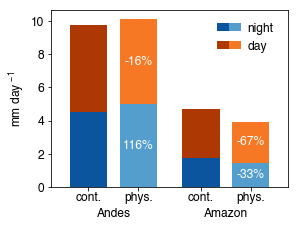

In [29]:
fontsize = 12
fig = mp.figure(figsize=(4.25,3.25))

ax = fig.add_subplot(111)
ax.tick_params(labelsize=fontsize)

loc1=1
loc2=2
loc3=3.25
loc4=4.25
barwidth = .75

ax.set_xlim(loc1-.75,loc4+.75)
ax.bar(loc1,raintot_diffs_400_PMtoAM_and*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc1,raintot_diffs_400_AMtoPM_and*24.,bottom=raintot_diffs_400_PMtoAM_and*24.,fc=orange_cmap[-1],width=barwidth)

ax.bar(loc2,raintot_diffs_1000_PMtoAM_and*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc2,raintot_diffs_1000_AMtoPM_and*24.,bottom=raintot_diffs_1000_PMtoAM_and*24.,fc=orange_cmap[-3],width=barwidth)

ax.set_xticklabels([])
ax.set_xticks([loc1,loc2,loc3,loc4])

ax.bar(loc3,raintot_diffs_400_PMtoAM_ama*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc3,raintot_diffs_400_AMtoPM_ama*24.,bottom=raintot_diffs_400_PMtoAM_ama*24.,fc=orange_cmap[-1],width=barwidth)

ax.bar(loc4,raintot_diffs_1000_PMtoAM_ama*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc4,raintot_diffs_1000_AMtoPM_ama*24.,bottom=raintot_diffs_1000_PMtoAM_ama*24.,fc=orange_cmap[-3],width=barwidth)

ax.set_yticks([0,2,4,6,8,10])
ax.set_ylabel('mm day$^{\,-1}$', fontsize=fontsize)

ax.text(s='cont.',x=loc1,y=-.25,fontsize=fontsize,ha='center',va='top')
ax.text(s='phys.',x=loc2,y=-.25,fontsize=fontsize,ha='center',va='top')
ax.text(s='cont.',x=loc3,y=-.25,fontsize=fontsize,ha='center',va='top')
ax.text(s='phys.',x=loc4,y=-.25,fontsize=fontsize,ha='center',va='top')
ax.text(s='Andes',x=.5*(loc1+loc2),y=-1.25,fontsize=fontsize,ha='center',va='top')
ax.text(s='Amazon',x=.5*(loc3+loc4),y=-1.25,fontsize=fontsize,ha='center',va='top')


# andes night
fraction = and_PMtoAM_diff/and_total_diff
y0 = 0
y1 = raintot_diffs_1000_PMtoAM_and*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc2,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='1')
# andes day
fraction = and_AMtoPM_diff/and_total_diff
y0 = raintot_diffs_1000_PMtoAM_and*24
y1 = (raintot_diffs_1000_PMtoAM_and+raintot_diffs_1000_AMtoPM_and)*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc2,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='1')


# amazon night
fraction = -ama_PMtoAM_diff/ama_total_diff
y0 = 0
y1 = raintot_diffs_1000_PMtoAM_ama*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc4,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='1')
# amazon day
fraction = -ama_AMtoPM_diff/ama_total_diff
y0 = raintot_diffs_1000_PMtoAM_ama*24
y1 = (raintot_diffs_1000_AMtoPM_ama+raintot_diffs_1000_PMtoAM_ama)*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc4,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='1')


handles = [mp.Rectangle((0,0),1,1) for i  in range(2)]
colors = [[blue_cmap[-1],blue_cmap[-3]],[orange_cmap[-1],orange_cmap[-3]]]
hmap = dict(zip(handles, [Handler(color_list[0],color_list[1]) for color_list in colors] ))

labels = ['night', 'day']
ax.legend(handles=handles, labels=labels, handler_map=hmap, fontsize=fontsize,\
          loc='upper right', bbox_to_anchor=(.95,.95), borderaxespad=0, labelspacing=0.5, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, handletextpad=0.5)

# big panel plot

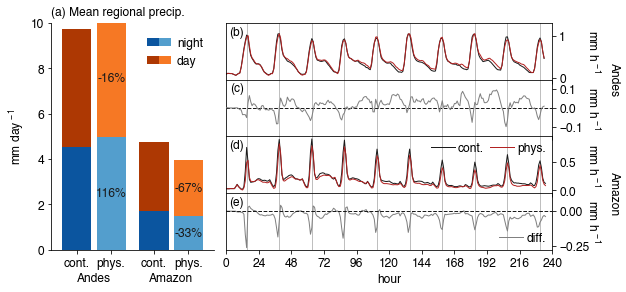

In [50]:
fontsize = 12

fig = mp.figure(figsize=(8.5,4))

gs = matplotlib.gridspec.GridSpec(4,2,width_ratios=[1,2])


ax1 = fig.add_subplot(gs[0,1])
ax1.plot(numpy.arange(raintot_diffs_400_latlon_mean_and.size)-5, raintot_diffs_400_latlon_mean_and,\
       color='0.1',lw=1,label='cont.')
ax1.plot(numpy.arange(raintot_diffs_400_latlon_mean_and.size)-5, raintot_diffs_1000_latlon_mean_and,\
       color='firebrick',lw=1,label='phys.')
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax1.yaxis.set_label_coords(1.1,0.5)
ax1.yaxis.tick_right()
ax1.set_xticks(numpy.arange(0,241,24))
ax1.set_xlim(0,240)
handles, labels = ax1.get_legend_handles_labels()
ax1.set_xticks(numpy.arange(15,241,24), minor=True)
ax1.xaxis.grid(which='minor')
ax1.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
#ax1.set_ylim(-.2,ax1.get_ylim()[1])
ax1.set_ylim(ax1.get_ylim()[0],1.3)


ax2 = fig.add_subplot(gs[1,1], sharex=ax1)
ax2.plot(numpy.arange(raintot_diffs_400_latlon_mean_and.size)-5, (raintot_diffs_1000_latlon_mean_and-raintot_diffs_400_latlon_mean_and),\
       color='0.5',lw=1,label='diff.',zorder=3)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax2.yaxis.set_label_coords(1.1,0.5)
ax2.yaxis.tick_right()
ax2.set_xticks(numpy.arange(0,241,24))
#ax2.set_yticks([-.05,0,.05])
ax2.set_xlim(0,240)
ax2.axhline(0, lw=1, ls='--', c='0.1')
ax2.set_xticks(numpy.arange(18,241,24), minor=True)
ax2.xaxis.grid(which='minor')
ax2.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
ax2.set_ylim(-.15,.15)

ax3 = fig.add_subplot(gs[2,1], sharex=ax1)
ax3.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_400_latlon_mean_ama,\
       color='0.1',lw=1,label='cont.')
ax3.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_1000_latlon_mean_ama,\
       color='firebrick',lw=1,label='phys.')
ax3.tick_params(labelsize=fontsize)
ax3.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax3.yaxis.set_label_coords(1.1,0.5)
ax3.yaxis.tick_right()
ax3.set_xticks(numpy.arange(0,241,24))
ax3.set_xlim(0,240)
ax3.xaxis.grid(which='minor')
ax3.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=2, bbox_to_anchor=(.99,.95), bbox_transform=ax3.transAxes, \
          loc='upper right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)
ax3.set_xticks(numpy.arange(15,241,24), minor=True)



ax4 = fig.add_subplot(gs[3,1], sharex=ax1)
ax4.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, (raintot_diffs_1000_latlon_mean_ama-raintot_diffs_400_latlon_mean_ama),\
       color='0.5',lw=1,label='diff.')
ax4.tick_params(labelsize=fontsize)
ax4.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax4.yaxis.set_label_coords(1.1,0.5)
ax4.yaxis.tick_right()
ax4.set_xticks(numpy.arange(0,241,24))
ax4.set_xlim(0,240)
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=1, bbox_to_anchor=(.99,.05), bbox_transform=ax4.transAxes, \
          loc='lower right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)
ax4.set_xticks(numpy.arange(15,241,24), minor=True)
ax4.xaxis.grid(which='minor')
ax4.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
ax4.axhline(0, lw=1, ls='--', c='0.1')
ax4.set_ylim(ax4.get_ylim()[0],0.13)
ax4.set_xlabel('hour', fontsize=fontsize)
#ax4.set_xticklabels(ax4.get_xticks())

################################################################################
################################################################################
ax = fig.add_subplot(gs[:,0])
ax.tick_params(labelsize=fontsize)
loc1=1
loc2=2
loc3=3.25
loc4=4.25
barwidth = .85

ax.set_xlim(loc1-.75,loc4+.75)
ax.bar(loc1,raintot_diffs_400_PMtoAM_and*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc1,raintot_diffs_400_AMtoPM_and*24.,bottom=raintot_diffs_400_PMtoAM_and*24.,fc=orange_cmap[-1],width=barwidth)
ax.bar(loc2,raintot_diffs_1000_PMtoAM_and*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc2,raintot_diffs_1000_AMtoPM_and*24.,bottom=raintot_diffs_1000_PMtoAM_and*24.,fc=orange_cmap[-3],width=barwidth)
ax.set_xticklabels([])
ax.set_xticks([loc1,loc2,loc3,loc4])
ax.bar(loc3,raintot_diffs_400_PMtoAM_ama*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc3,raintot_diffs_400_AMtoPM_ama*24.,bottom=raintot_diffs_400_PMtoAM_ama*24.,fc=orange_cmap[-1],width=barwidth)
ax.bar(loc4,raintot_diffs_1000_PMtoAM_ama*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc4,raintot_diffs_1000_AMtoPM_ama*24.,bottom=raintot_diffs_1000_PMtoAM_ama*24.,fc=orange_cmap[-3],width=barwidth)
ax.set_yticks([0,2,4,6,8,10])
ax.set_ylabel('mm day$^{\,-1}$', fontsize=fontsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0,10)

ax.set_xticklabels(['cont.','phys.','cont.','phys.'])
ax.text(s='Andes',x=.5*(loc1+loc2),y=-1,fontsize=fontsize,ha='center',va='top')
ax.text(s='Amazon',x=.5*(loc3+loc4),y=-1,fontsize=fontsize,ha='center',va='top')
# andes night
fraction = and_PMtoAM_diff/and_total_diff
y0 = 0
y1 = raintot_diffs_1000_PMtoAM_and*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc2,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='0.1')
# andes day
fraction = and_AMtoPM_diff/and_total_diff
y0 = raintot_diffs_1000_PMtoAM_and*24
y1 = (raintot_diffs_1000_PMtoAM_and+raintot_diffs_1000_AMtoPM_and)*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc2,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='0.1')
# amazon night
fraction = -ama_PMtoAM_diff/ama_total_diff
y0 = 0
y1 = raintot_diffs_1000_PMtoAM_ama*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc4,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='0.1')
# amazon day
fraction = -ama_AMtoPM_diff/ama_total_diff
y0 = raintot_diffs_1000_PMtoAM_ama*24
y1 = (raintot_diffs_1000_AMtoPM_ama+raintot_diffs_1000_PMtoAM_ama)*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc4,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='0.1')

handles = [mp.Rectangle((0,0),1,1) for i  in range(2)]
colors = [[blue_cmap[-1],blue_cmap[-3]],[orange_cmap[-1],orange_cmap[-3]]]
hmap = dict(zip(handles, [Handler(color_list[0],color_list[1]) for color_list in colors] ))
labels = ['night', 'day']
ax.legend(handles=handles, labels=labels, handler_map=hmap, fontsize=fontsize,\
          loc='upper right', bbox_to_anchor=(.95,.95), borderaxespad=0, labelspacing=0.5, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, handletextpad=0.5)

mp.setp(ax1.get_xticklabels(), visible=False)
mp.setp(ax2.get_xticklabels(), visible=False)
mp.setp(ax3.get_xticklabels(), visible=False)

fig.tight_layout()
gs.update(hspace=0.,wspace=0.05)

ax1.text(s='Andes', x=285, y=ax1.get_ylim()[0],\
        ha='center',va='center',rotation=-90, fontsize=fontsize)

ax3.text(s='Amazon', x=285, y=ax3.get_ylim()[0],\
        ha='center',va='center',rotation=-90, fontsize=fontsize)


ax.text(s='(a) Mean regional precip.', x=0, y=1.02, fontsize=fontsize, ha='left', va='bottom', transform=ax.transAxes)
ax1.text(s='(b)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax1.transAxes)
ax2.text(s='(c)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax2.transAxes)
ax3.text(s='(d)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax3.transAxes)
ax4.text(s='(e)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax4.transAxes)

fig.savefig('precip_change_and_percentages_daynight.png', dpi=600, bbox_inches='tight', transparent=True)



# also do for precip over mountainous areas ONLY

In [84]:
mp.rcParams.update({'mathtext.default': 'regular'})

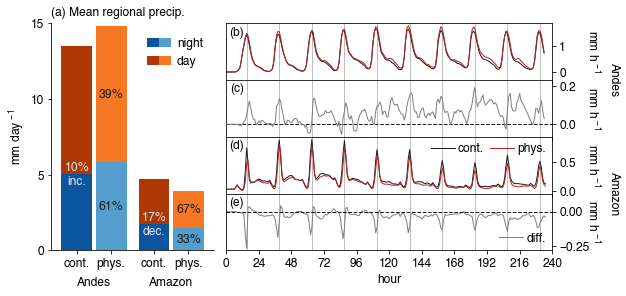

In [104]:
fontsize = 12

fig = mp.figure(figsize=(8.5,4))

gs = matplotlib.gridspec.GridSpec(4,2,width_ratios=[1,2])


ax1 = fig.add_subplot(gs[0,1])
ax1.plot(numpy.arange(raintot_diffs_400_latlon_mean_and_high.size)-5, raintot_diffs_400_latlon_mean_and_high,\
       color='0.1',lw=1,label='cont.')
ax1.plot(numpy.arange(raintot_diffs_400_latlon_mean_and_high.size)-5, raintot_diffs_1000_latlon_mean_and_high,\
       color='firebrick',lw=1,label='phys.')
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax1.yaxis.set_label_coords(1.1,0.5)
ax1.yaxis.tick_right()
ax1.set_xticks(numpy.arange(0,241,24))
ax1.set_xlim(0,240)
handles, labels = ax1.get_legend_handles_labels()
ax1.set_xticks(numpy.arange(15,241,24), minor=True)
ax1.xaxis.grid(which='minor')
ax1.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
ax1.set_ylim(-.3,ax1.get_ylim()[1])
#ax1.set_ylim(-.5,ax1.get_ylim()[1])


ax2 = fig.add_subplot(gs[1,1], sharex=ax1)
ax2.plot(numpy.arange(raintot_diffs_400_latlon_mean_and_high.size)-5, (raintot_diffs_1000_latlon_mean_and_high-raintot_diffs_400_latlon_mean_and_high),\
       color='0.5',lw=1,label='diff.',zorder=3)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax2.yaxis.set_label_coords(1.1,0.5)
ax2.yaxis.tick_right()
ax2.set_xticks(numpy.arange(0,241,24))
#ax2.set_yticks([-.05,0,.05])
ax2.set_xlim(0,240)
ax2.axhline(0, lw=1, ls='--', c='0.1')
ax2.set_xticks(numpy.arange(18,241,24), minor=True)
ax2.xaxis.grid(which='minor')
ax2.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
ax2.set_ylim(ax2.get_ylim()[0],.23)

ax3 = fig.add_subplot(gs[2,1], sharex=ax1)
ax3.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_400_latlon_mean_ama,\
       color='0.1',lw=1,label='cont.')
ax3.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_1000_latlon_mean_ama,\
       color='firebrick',lw=1,label='phys.')
ax3.tick_params(labelsize=fontsize)
ax3.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax3.yaxis.set_label_coords(1.1,0.5)
ax3.yaxis.tick_right()
ax3.set_xticks(numpy.arange(0,241,24))
ax3.set_xlim(0,240)
ax3.xaxis.grid(which='minor')
ax3.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=2, bbox_to_anchor=(.99,.95), bbox_transform=ax3.transAxes, \
          loc='upper right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)
ax3.set_xticks(numpy.arange(15,241,24), minor=True)



ax4 = fig.add_subplot(gs[3,1], sharex=ax1)
ax4.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, (raintot_diffs_1000_latlon_mean_ama-raintot_diffs_400_latlon_mean_ama),\
       color='0.5',lw=1,label='diff.')
ax4.tick_params(labelsize=fontsize)
ax4.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax4.yaxis.set_label_coords(1.1,0.5)
ax4.yaxis.tick_right()
ax4.set_xticks(numpy.arange(0,241,24))
ax4.set_xlim(0,240)
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=1, bbox_to_anchor=(.99,.05), bbox_transform=ax4.transAxes, \
          loc='lower right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)
ax4.set_xticks(numpy.arange(15,241,24), minor=True)
ax4.xaxis.grid(which='minor')
ax4.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
ax4.axhline(0, lw=1, ls='--', c='0.1')
ax4.set_ylim(ax4.get_ylim()[0],0.13)
ax4.set_xlabel('hour', fontsize=fontsize)
#ax4.set_xticklabels(ax4.get_xticks())

################################################################################
################################################################################
ax = fig.add_subplot(gs[:,0])
ax.tick_params(labelsize=fontsize)
loc1=1
loc2=2
loc3=3.25
loc4=4.25
barwidth = .9

ax.set_xlim(loc1-.75,loc4+.75)
ax.bar(loc1,raintot_diffs_400_PMtoAM_and_high*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc1,raintot_diffs_400_AMtoPM_and_high*24.,bottom=raintot_diffs_400_PMtoAM_and_high*24.,fc=orange_cmap[-1],width=barwidth)
ax.bar(loc2,raintot_diffs_1000_PMtoAM_and_high*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc2,raintot_diffs_1000_AMtoPM_and_high*24.,bottom=raintot_diffs_1000_PMtoAM_and_high*24.,fc=orange_cmap[-3],width=barwidth)
ax.set_xticklabels([])
ax.set_xticks([loc1,loc2,loc3,loc4])
ax.bar(loc3,raintot_diffs_400_PMtoAM_ama*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc3,raintot_diffs_400_AMtoPM_ama*24.,bottom=raintot_diffs_400_PMtoAM_ama*24.,fc=orange_cmap[-1],width=barwidth)
ax.bar(loc4,raintot_diffs_1000_PMtoAM_ama*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc4,raintot_diffs_1000_AMtoPM_ama*24.,bottom=raintot_diffs_1000_PMtoAM_ama*24.,fc=orange_cmap[-3],width=barwidth)
ax.set_yticks([0,5,10,15])
ax.set_ylabel('mm day$^{\,-1}$', fontsize=fontsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0,15)

ax.set_xticklabels(['cont.','phys.','cont.','phys.'])
ax.text(s='Andes',x=.5*(loc1+loc2),y=-1.75,fontsize=fontsize,ha='center',va='top')
ax.text(s='Amazon',x=.5*(loc3+loc4),y=-1.75,fontsize=fontsize,ha='center',va='top')
# andes night
fraction = and_high_PMtoAM_diff/and_high_total_diff
y0 = raintot_diffs_1000_PMtoAM_and_high*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc2,y=0.5*y0,ha='center',va='center',fontsize=fontsize,color='0.1')
# andes day
fraction = and_high_AMtoPM_diff/and_high_total_diff
y0 = raintot_diffs_1000_PMtoAM_and_high*24
y1 = raintot_diffs_1000_AMtoPM_and_high*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc2,y=y0+0.5*y1,ha='center',va='center',fontsize=fontsize,color='0.1')
# amazon night
fraction = ama_PMtoAM_diff/ama_total_diff
y0 = raintot_diffs_1000_PMtoAM_ama*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc4,y=0.5*y0,ha='center',va='center',fontsize=fontsize,color='0.1')
# amazon day
fraction = ama_AMtoPM_diff/ama_total_diff
y0 = raintot_diffs_1000_PMtoAM_ama*24
y1 = raintot_diffs_1000_AMtoPM_ama*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc4,y=y0+0.5*y1,ha='center',va='center',fontsize=fontsize,color='0.1')

fraction = and_high_total_diff/raintot_diffs_400_timemean_and_high
y0 = raintot_diffs_400_PMtoAM_and_high*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%\ninc.',x=loc1,y=y0,ha='center',va='center',fontsize=fontsize,color='.9')

fraction = -ama_total_diff/raintot_diffs_400_timemean_ama
y0 = raintot_diffs_400_PMtoAM_ama*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%\ndec.',x=loc3,y=y0,ha='center',va='center',fontsize=fontsize,color='.9')

handles = [mp.Rectangle((0,0),1,1) for i  in range(2)]
colors = [[blue_cmap[-1],blue_cmap[-3]],[orange_cmap[-1],orange_cmap[-3]]]
hmap = dict(zip(handles, [Handler(color_list[0],color_list[1]) for color_list in colors] ))
labels = ['night', 'day']
ax.legend(handles=handles, labels=labels, handler_map=hmap, fontsize=fontsize,\
          loc='upper right', bbox_to_anchor=(.95,.95), borderaxespad=0, labelspacing=0.5, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, handletextpad=0.5)

mp.setp(ax1.get_xticklabels(), visible=False)
mp.setp(ax2.get_xticklabels(), visible=False)
mp.setp(ax3.get_xticklabels(), visible=False)

fig.tight_layout()
gs.update(hspace=0.,wspace=0.05)

ax1.text(s='Andes', x=285, y=ax1.get_ylim()[0],\
        ha='center',va='center',rotation=-90, fontsize=fontsize)

ax3.text(s='Amazon', x=285, y=ax3.get_ylim()[0],\
        ha='center',va='center',rotation=-90, fontsize=fontsize)


ax.text(s='(a) Mean regional precip.', x=0, y=1.02, fontsize=fontsize, ha='left', va='bottom', transform=ax.transAxes)
ax1.text(s='(b)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax1.transAxes)
ax2.text(s='(c)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax2.transAxes)
ax3.text(s='(d)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax3.transAxes)
ax4.text(s='(e)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax4.transAxes)

fig.savefig('precip_change_and_high_percentages_daynight_high_andes.png', dpi=600, bbox_inches='tight', transparent=True)



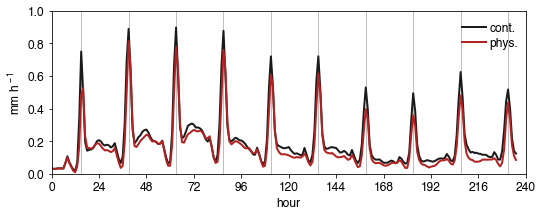

In [171]:
fontsize = 12

fig = mp.figure(figsize=(8.5,3))

ax = fig.add_subplot(111)

ax.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_400_latlon_mean_ama,\
       color='0.1',lw=2,label='cont.')
ax.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_1000_latlon_mean_ama,\
       color='firebrick',lw=2,label='phys.')

ax.tick_params(labelsize=fontsize)
ax.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize)
ax.set_xlabel('hour', fontsize=fontsize)

ax.set_xticks(numpy.arange(0,241,24))
ax.set_yticks([0,.2,.4,.6,.8,1])
ax.set_xlim(0,240)
ax.set_ylim(0,1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=1, bbox_to_anchor=(.99,.95), bbox_transform=ax.transAxes, \
          loc='upper right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)

ax.set_xticks(numpy.arange(15,241,24), minor=True)
#ax.set_xticks(numpy.arange(20,241,24), minor=True)
#ax.minorticks_off()
ax.xaxis.grid(which='minor')

ax.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)


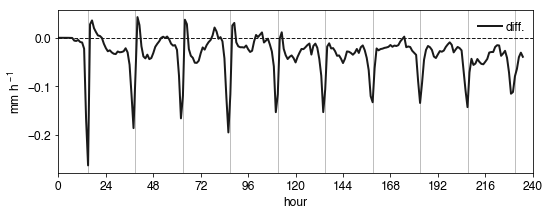

In [148]:
fontsize = 12

fig = mp.figure(figsize=(8.5,3))

ax = fig.add_subplot(111)

ax.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_1000_latlon_mean_ama-raintot_diffs_400_latlon_mean_ama,\
       color='0.1',lw=2,label='diff.')
# ax.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_1000_latlon_mean_ama,\
#        color='firebrick',lw=2,label='phys.')

ax.tick_params(labelsize=fontsize)
ax.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize)
ax.set_xlabel('hour', fontsize=fontsize)

ax.set_xticks(numpy.arange(0,241,24))
#ax.set_yticks([0,.2,.4,.6,.8])
ax.set_xlim(0,240)
#ax.set_ylim(0,.85)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=1, bbox_to_anchor=(.99,.95), bbox_transform=ax.transAxes, \
          loc='upper right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)

ax.set_xticks(numpy.arange(15,241,24), minor=True)
#ax.minorticks_off()
ax.xaxis.grid(which='minor')

ax.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
ax.axhline(0, lw=1, ls='--', c='0.1')

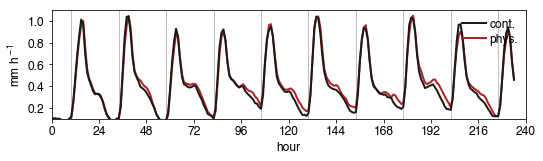

In [186]:
fontsize = 12

fig = mp.figure(figsize=(8.5,2))

ax = fig.add_subplot(111)

ax.plot(numpy.arange(raintot_diffs_400_latlon_mean_and.size)-5, raintot_diffs_400_latlon_mean_and,\
       color='0.1',lw=2,label='cont.',zorder=3)
ax.plot(numpy.arange(raintot_diffs_400_latlon_mean_and.size)-5, raintot_diffs_1000_latlon_mean_and,\
       color='firebrick',lw=2,label='phys.')

ax.tick_params(labelsize=fontsize)
ax.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize)
ax.set_xlabel('hour', fontsize=fontsize)

ax.set_xticks(numpy.arange(0,241,24))
ax.set_yticks([0,.2,.4,.6,.8,1])
ax.set_xlim(0,240)
ax.set_ylim(0.1,1.1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=1, bbox_to_anchor=(.99,.95), bbox_transform=ax.transAxes, \
          loc='upper right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)

ax.set_xticks(numpy.arange(10,241,24), minor=True)
ax.xaxis.grid(which='minor')

ax.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)


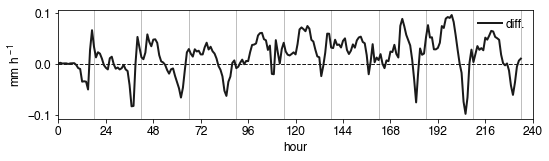

In [184]:
fontsize = 12

fig = mp.figure(figsize=(8.5,2))

ax = fig.add_subplot(111)

ax.plot(numpy.arange(raintot_diffs_400_latlon_mean_and.size)-5, raintot_diffs_1000_latlon_mean_and-raintot_diffs_400_latlon_mean_and,\
       color='0.1',lw=2,label='diff.',zorder=3)
# ax.plot(numpy.arange(raintot_diffs_400_latlon_mean_and.size)-5, raintot_diffs_1000_latlon_mean_and,\
#        color='firebrick',lw=2,label='phys.')

ax.tick_params(labelsize=fontsize)
ax.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize)
ax.set_xlabel('hour', fontsize=fontsize)

ax.set_xticks(numpy.arange(0,241,24))
#ax.set_yticks([0,.2,.4,.6,.8,1])
ax.set_xlim(0,240)
#ax.set_ylim(0.1,1.1)
ax.axhline(0, lw=1, ls='--', c='0.1')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=1, bbox_to_anchor=(.99,.95), bbox_transform=ax.transAxes, \
          loc='upper right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)

ax.set_xticks(numpy.arange(18,241,24), minor=True)
ax.xaxis.grid(which='minor')

ax.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)


# tk diffs

In [562]:
tk_400_latlon_subset = tk_400[:,:,latlon_indices]
tk_1000_latlon_subset = tk_1000[:,:,latlon_indices]

tk_400_latlon_mean = numpy.nanmean(tk_400_latlon_subset, axis=2)
tk_1000_latlon_mean = numpy.nanmean(tk_1000_latlon_subset, axis=2)

In [563]:
tk_400_latlon_alltime = numpy.nanmean(tk_400_latlon_subset, axis=(0,2))
tk_1000_latlon_alltime = numpy.nanmean(tk_1000_latlon_subset, axis=(0,2))

# qvapor diffs

In [564]:
qvapor_400_latlon_subset = qvapor_400.values[:,:,latlon_indices]
qvapor_1000_latlon_subset = qvapor_1000.values[:,:,latlon_indices]

qvapor_400_latlon_mean = numpy.nanmean(qvapor_400_latlon_subset, axis=(2))
qvapor_1000_latlon_mean = numpy.nanmean(qvapor_1000_latlon_subset, axis=(2))

qvapor_diffs_latlon_mean = qvapor_1000_latlon_mean-qvapor_400_latlon_mean

# cape diffs

In [565]:
cape3d_cape_400_latlon_subset = cape3d_400[0,:,:,:,:][:,:,latlon_indices]
cape3d_cape_1000_latlon_subset = cape3d_1000[0,:,:,:,:][:,:,latlon_indices]

cape3d_cape_diffs_latlon_mean = numpy.nanmean((cape3d_cape_1000_latlon_subset-cape3d_cape_400_latlon_subset), axis=2)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [368]:
cape2d_diffs = cape2d_1000-cape2d_400

cape2d_mcape_diffs = cape2d_diffs[0,:,:,:]
cape2d_mcin_diffs = cape2d_diffs[1,:,:,:]
cape2d_lcl_diffs = cape2d_diffs[2,:,:,:]
cape2d_lfc_diffs = cape2d_diffs[3,:,:,:]

# plot skew T

In [566]:
metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                  (tk_400_latlon_afternoon[:]-273.15)*metpy.units.units.degC, \
                                  (td_400_latlon_afternoon[:]-273.15)*metpy.units.units.degC)

(<Quantity(3160.3842649923386, 'joule / kilogram')>,
 <Quantity(-4.464507233670379, 'joule / kilogram')>)

# cape calculations

In [567]:
ptot_lo = 100
ptot_hi = 1013.25
hour = 19

ptot_indices = (ptot_latlon_subset_timemean/100.<=ptot_hi)&(ptot_latlon_subset_timemean/100.>=ptot_lo)

cape_400 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_400_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_400_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC)

cape_1000 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_1000_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_1000_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC)

print(cape_400)
print(cape_1000)

(<Quantity(1494.3210756503593, 'joule / kilogram')>, <Quantity(-0.13637772152277114, 'joule / kilogram')>)
(<Quantity(1329.3341172021608, 'joule / kilogram')>, <Quantity(1.116310558771464, 'joule / kilogram')>)


3-hour afternoon mean

In [568]:
color_list = [\
matplotlib.cm.tab20c(4/20), \
matplotlib.cm.tab20c(5.5/20), \
matplotlib.cm.tab20c(0/20), \
matplotlib.cm.tab20c(1.5/20) ]

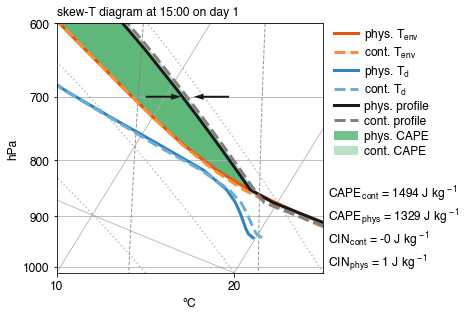

In [570]:
fontsize=12
hour = 19

skewt_plot = metpy.plots.SkewT()

skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_1000_latlon_mean[hour,:]-273.15, lw=3, label='phys. T$_{env}$', c=color_list[0])
skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_400_latlon_mean[hour,:]-273.15, lw=3, label='cont. T$_{env}$', ls='--', c=color_list[1])
skewt_plot.plot(ptot_latlon_subset_timemean/100., td_1000_latlon_mean[hour,:]-273.15, lw=3, label='phys. T$_d$', c=color_list[2])
skewt_plot.plot(ptot_latlon_subset_timemean/100., td_400_latlon_mean[hour,:]-273.15, lw=3, label='cont. T$_d$', ls='--', c=color_list[3])

pprofile_400 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_400_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC, \
                                         (td_400_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC).to('degC')
pprofile_1000 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_1000_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC, \
                                         (td_1000_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC).to('degC')

skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_1000, label='phys. profile', c='0.1', lw=3, ls='-')
skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_400, label='cont. profile', c='0.5', lw=3, ls='--')


# fill in control and phys CAPE
skewt_plot.shade_cape(ptot_latlon_subset_timemean/100.,\
                      tk_1000_latlon_mean[hour,:]-273.15,\
                      numpy.array(pprofile_1000),\
                      edgecolor='None',facecolor=matplotlib.cm.tab20c(8/20),alpha=0.666,\
                      label='phys. CAPE')

skewt_plot.shade_cape(ptot_latlon_subset_timemean/100.,\
                      tk_400_latlon_mean[hour,:]-273.15,\
                      numpy.array(pprofile_400),\
                      edgecolor='None',facecolor=matplotlib.cm.tab20c(8/20),alpha=0.333,\
                      label='cont. CAPE')

skewt_plot.ax.set_ylim(1013.25,600)
skewt_plot.ax.set_xlim(10,25)

fig = mp.gcf()
fig.set_size_inches(4.45,4.25)
fig.tight_layout()

skewt_plot.ax.tick_params(labelsize=fontsize)
skewt_plot.ax.set_ylabel('hPa', fontsize=fontsize)
skewt_plot.ax.set_xlabel('$\degree$C', fontsize=fontsize)

skewt_plot.plot_dry_adiabats(color='0.5',linewidth=1,linestyle='-')
skewt_plot.plot_moist_adiabats(color='0.5',linestyle=':')
skewt_plot.plot_mixing_lines(color='0.5',linestyle='--',lw=1)

handles, labels = skewt_plot.ax.get_legend_handles_labels()
skewt_plot.ax.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
                     bbox_to_anchor=(1.03,1.0), \
                     bbox_transform=skewt_plot.ax.transAxes, loc='upper left', \
                     borderaxespad=0, labelspacing=0.25, fancybox=False, \
                     edgecolor='0', framealpha=0, borderpad=0.25, \
                     columnspacing=0.5, handletextpad=0.5, markerscale=1)

skewt_plot.ax.text(s='skew-T diagram at 15:00 on day 1',\
                  x=0,y=1.02,\
                  transform=skewt_plot.ax.transAxes,\
                  ha='left',va='bottom', fontsize=fontsize)

skewt_plot.ax.annotate("",xy=(11.6,700), \
                       xycoords='data',\
                       xytext=(13.6, 700), \
                       textcoords='data',\
                       arrowprops=dict(facecolor='0.1',ec='None',width=2,headwidth=6,headlength=10))

skewt_plot.ax.annotate("",xy=(10.9,700), \
                       xycoords='data',\
                       xytext=(8.9, 700), \
                       textcoords='data',\
                       arrowprops=dict(facecolor='0.1',ec='None',width=2,headwidth=6,headlength=10))

CAPE_CIN_text = 'CAPE$_{\,cont}$ = '+'{:.0f}'.format(numpy.array(cape_400[0]))+' J kg$^{\,-1}$\n'\
                'CAPE$_{\,phys}$ = '+'{:.0f}'.format(numpy.array(cape_1000[0]))+' J kg$^{\,-1}$\n'\
                'CIN$_{\,cont}$ = '+'{:.0f}'.format(numpy.array(cape_400[1]))+' J kg$^{\,-1}$\n'\
                'CIN$_{\,phys}$ = '+'{:.0f}'.format(numpy.array(cape_1000[1]))+' J kg$^{\,-1}$'
skewt_plot.ax.text(s=CAPE_CIN_text,x=1.02,y=0,ha='left',va='bottom',transform=skewt_plot.ax.transAxes,fontsize=fontsize)

fig.savefig('manuscript_both_cape_skewT_hour'+str(hour-4)+'_zoom_andes_region.png', dpi=600, bbox_inches='tight', transparent=True)

In [521]:
ptot_latlon_subset_timemean

array([98988.7   , 98177.6   , 97081.016 , 95699.65  , 93986.85  ,
       91848.81  , 89287.35  , 85631.54  , 81077.586 , 76537.695 ,
       72010.04  , 65841.89  , 58397.23  , 51654.656 , 45552.992 ,
       40037.746 , 35059.363 , 30573.596 , 26540.547 , 22925.326 ,
       19698.107 , 16828.598 , 14325.336 , 12189.765 , 10372.6045,
        8826.341 ,  7510.532 ,  6390.814 ,  5438.001 ], dtype=float32)

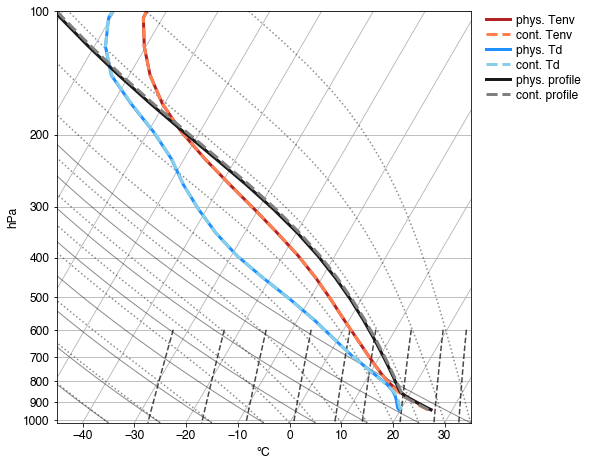

In [571]:
fontsize=12
hour = 18

skewt_plot = metpy.plots.SkewT()

skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_1000_latlon_mean[hour,:]-273.15, lw=3, label='phys. Tenv', c='firebrick')
skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_400_latlon_mean[hour,:]-273.15, lw=3, label='cont. Tenv', c='coral', ls='--')

skewt_plot.plot(ptot_latlon_subset_timemean/100., td_1000_latlon_mean[hour,:]-273.15, lw=3, label='phys. Td', c='dodgerblue')
skewt_plot.plot(ptot_latlon_subset_timemean/100., td_400_latlon_mean[hour,:]-273.15, lw=3, label='cont. Td', c='skyblue', ls='--')

pprofile_400 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_400_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC, \
                                         (td_400_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC).to('degC')
pprofile_1000 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_1000_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC, \
                                         (td_1000_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC).to('degC')

skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_1000, label='phys. profile', c='0.1', lw=3, ls='-')
skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_400, label='cont. profile', c='0.5', lw=3, ls='--')

skewt_plot.ax.set_ylim(1013.25,100)
skewt_plot.ax.set_xlim(-45,35)

fig = mp.gcf()
fig.set_size_inches(6.5,6.5)
fig.tight_layout()

skewt_plot.ax.tick_params(labelsize=fontsize)
skewt_plot.ax.set_ylabel('hPa', fontsize=fontsize)
skewt_plot.ax.set_xlabel('$\degree$C', fontsize=fontsize)

skewt_plot.plot_dry_adiabats(color='0.1',linewidth=1,linestyle='-')
skewt_plot.plot_moist_adiabats(color='0.1',linestyle=':')
skewt_plot.plot_mixing_lines(color='0.1',linestyle='--')

handles, labels = skewt_plot.ax.get_legend_handles_labels()
skewt_plot.ax.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
                     bbox_to_anchor=(1.03,1.0), \
                     bbox_transform=skewt_plot.ax.transAxes, loc='upper left', \
                     borderaxespad=0, labelspacing=0.25, fancybox=False, \
                     edgecolor='0', framealpha=0, borderpad=0.25, \
                     columnspacing=0.5, handletextpad=0.5, markerscale=1)

fig.savefig('both_cape_skewT_hour'+str(hour-4)+'_andes_region.png', dpi=600, bbox_inches='tight', transparent=True)

# 10 day mean skewT diagrams

In [572]:
time_datetimes = pandas.to_datetime([i.decode('utf-8') for i in time], format = '%Y-%m-%d_%H:%M:%S')

In [577]:
hour_indices = [t.hour==19 and t.day in range(5,11) for t in time_datetimes]

In [578]:
ptot_lo = 100
ptot_hi = 1013.25

tk_400_latlon_afternoon = numpy.nanmean(tk_400_latlon_mean[hour_indices,:], axis=0)
td_400_latlon_afternoon = numpy.nanmean(td_400_latlon_mean[hour_indices,:], axis=0)

tk_1000_latlon_afternoon = numpy.nanmean(tk_1000_latlon_mean[hour_indices,:], axis=0)
td_1000_latlon_afternoon = numpy.nanmean(td_1000_latlon_mean[hour_indices,:], axis=0)

ptot_indices = (ptot_latlon_subset_timemean/100.<=ptot_hi)&(ptot_latlon_subset_timemean/100.>=ptot_lo)

cape_400 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_400_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_400_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC)

cape_1000 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_1000_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_1000_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC)

print(cape_400)
print(cape_1000)

(<Quantity(1515.4784712215214, 'joule / kilogram')>, <Quantity(-0.1279263776966598, 'joule / kilogram')>)
(<Quantity(1359.0473408126452, 'joule / kilogram')>, <Quantity(-2.384760147091529, 'joule / kilogram')>)


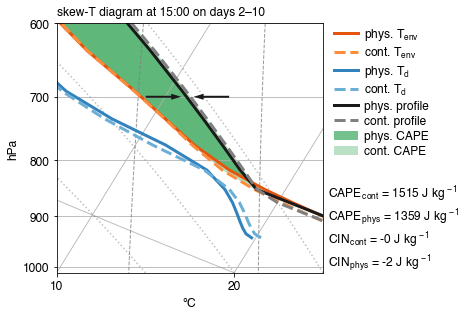

In [579]:
fontsize=12
hour = 19

skewt_plot = metpy.plots.SkewT()

skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_1000_latlon_afternoon-273.15, lw=3, label='phys. T$_{env}$', c=color_list[0])
skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_400_latlon_afternoon-273.15, lw=3, label='cont. T$_{env}$', ls='--', c=color_list[1])
skewt_plot.plot(ptot_latlon_subset_timemean/100., td_1000_latlon_afternoon-273.15, lw=3, label='phys. T$_d$', c=color_list[2])
skewt_plot.plot(ptot_latlon_subset_timemean/100., td_400_latlon_afternoon-273.15, lw=3, label='cont. T$_d$', ls='--', c=color_list[3])

pprofile_400 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_400_latlon_afternoon[0]-273.15)*metpy.units.units.degC, \
                                         (td_400_latlon_afternoon[0]-273.15)*metpy.units.units.degC).to('degC')
pprofile_1000 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_1000_latlon_afternoon[0]-273.15)*metpy.units.units.degC, \
                                         (td_1000_latlon_afternoon[0]-273.15)*metpy.units.units.degC).to('degC')

skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_1000, label='phys. profile', c='0.1', lw=3, ls='-')
skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_400, label='cont. profile', c='0.5', lw=3, ls='--')


# fill in control and phys CAPE
skewt_plot.shade_cape(ptot_latlon_subset_timemean/100.,\
                      tk_1000_latlon_afternoon-273.15,\
                      numpy.array(pprofile_1000),\
                      edgecolor='None',facecolor=matplotlib.cm.tab20c(8/20),alpha=0.666,\
                      label='phys. CAPE')

skewt_plot.shade_cape(ptot_latlon_subset_timemean/100.,\
                      tk_400_latlon_afternoon-273.15,\
                      numpy.array(pprofile_400),\
                      edgecolor='None',facecolor=matplotlib.cm.tab20c(8/20),alpha=0.333,\
                      label='cont. CAPE')

skewt_plot.ax.set_ylim(1013.25,600)
skewt_plot.ax.set_xlim(10,25)

fig = mp.gcf()
fig.set_size_inches(4.45,4.25)
fig.tight_layout()

skewt_plot.ax.tick_params(labelsize=fontsize)
skewt_plot.ax.set_ylabel('hPa', fontsize=fontsize)
skewt_plot.ax.set_xlabel('$\degree$C', fontsize=fontsize)

skewt_plot.plot_dry_adiabats(color='0.5',linewidth=1,linestyle='-')
skewt_plot.plot_moist_adiabats(color='0.5',linestyle=':')
skewt_plot.plot_mixing_lines(color='0.5',linestyle='--',lw=1)

handles, labels = skewt_plot.ax.get_legend_handles_labels()
skewt_plot.ax.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
                     bbox_to_anchor=(1.03,1.0), \
                     bbox_transform=skewt_plot.ax.transAxes, loc='upper left', \
                     borderaxespad=0, labelspacing=0.25, fancybox=False, \
                     edgecolor='0', framealpha=0, borderpad=0.25, \
                     columnspacing=0.5, handletextpad=0.5, markerscale=1)

skewt_plot.ax.text(s='skew-T diagram at 15:00 on days 2–10',\
                  x=0,y=1.02,\
                  transform=skewt_plot.ax.transAxes,\
                  ha='left',va='bottom', fontsize=fontsize)

skewt_plot.ax.annotate("",xy=(11.6,700), \
                       xycoords='data',\
                       xytext=(13.6, 700), \
                       textcoords='data',\
                       arrowprops=dict(facecolor='0.1',ec='None',width=2,headwidth=6,headlength=10))

skewt_plot.ax.annotate("",xy=(10.9,700), \
                       xycoords='data',\
                       xytext=(8.9, 700), \
                       textcoords='data',\
                       arrowprops=dict(facecolor='0.1',ec='None',width=2,headwidth=6,headlength=10))

CAPE_CIN_text = 'CAPE$_{\,cont}$ = '+'{:.0f}'.format(numpy.array(cape_400[0]))+' J kg$^{\,-1}$\n'\
                'CAPE$_{\,phys}$ = '+'{:.0f}'.format(numpy.array(cape_1000[0]))+' J kg$^{\,-1}$\n'\
                'CIN$_{\,cont}$ = '+'{:.0f}'.format(numpy.array(cape_400[1]))+' J kg$^{\,-1}$\n'\
                'CIN$_{\,phys}$ = '+'{:.0f}'.format(numpy.array(cape_1000[1]))+' J kg$^{\,-1}$'
skewt_plot.ax.text(s=CAPE_CIN_text,x=1.02,y=0,ha='left',va='bottom',transform=skewt_plot.ax.transAxes,fontsize=fontsize)

fig.savefig('manuscript_both_cape_skewT_hour'+str(hour-4)+'_zoom_ALL_DAYS_andes_region.png', dpi=600, bbox_inches='tight', transparent=True)

# plot cape variables in 4x4 plot for first day and 2-10 days

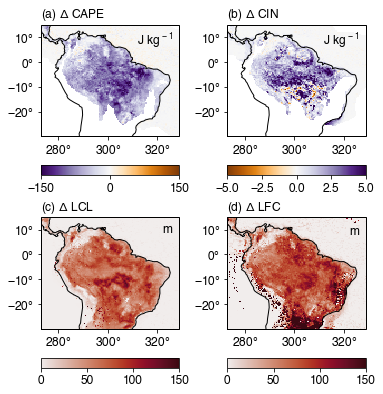

In [24]:
fig = mp.figure(figsize=(5.333,5.666))

fontsize=12
lon_offset=25.

map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(221, projection=map_proj)
ax2 = fig.add_subplot(222, projection=map_proj)
ax3 = fig.add_subplot(223, projection=map_proj)
ax4 = fig.add_subplot(224, projection=map_proj)

cp1 = ax1.pcolormesh(xlong,xlat,\
                     cape2d_mcape_diffs[:24,:,:].mean(axis=0),\
                     cmap='PuOr_r', vmin=-150,vmax=150)

cp2 = ax2.pcolormesh(xlong,xlat,\
                     cape2d_mcin_diffs[:24,:,:].mean(axis=0),\
                     cmap='PuOr', vmin=-5,vmax=5)

cp3 = ax3.pcolormesh(xlong,xlat,\
                     cape2d_lcl_diffs[:24,:,:].mean(axis=0),\
                     cmap=cmocean.cm.amp, vmin=0,vmax=150)

cp4 = ax4.pcolormesh(xlong,xlat,\
                     cape2d_lfc_diffs[:24,:,:].mean(axis=0),\
                     cmap=cmocean.cm.amp, vmin=0,vmax=150)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()

ax1.set_extent([273,329,-30,15], crs=map_proj)
ax2.set_extent([273,329,-30,15], crs=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax1.set_xticks([-360+280,-360+300,-360+320])
ax1.set_yticks([-20,-10,0,10])
ax1.tick_params(labelsize=fontsize)
ax1.set_xticklabels(['$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax1.set_yticklabels(['$-20$'+DEGREE_SIGN,'$-10$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$10$'+DEGREE_SIGN])

ax2.set_xticks([-360+280,-360+300,-360+320])
ax2.set_yticks([-20,-10,0,10])
ax2.tick_params(labelsize=fontsize)
ax2.set_xticklabels(['$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax2.set_yticklabels(['$-20$'+DEGREE_SIGN,'$-10$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$10$'+DEGREE_SIGN])

ax3.set_xticks([-360+280,-360+300,-360+320])
ax3.set_yticks([-20,-10,0,10])
ax3.tick_params(labelsize=fontsize)
ax3.set_xticklabels(['$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax3.set_yticklabels(['$-20$'+DEGREE_SIGN,'$-10$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$10$'+DEGREE_SIGN])

ax4.set_xticks([-360+280,-360+300,-360+320])
ax4.set_yticks([-20,-10,0,10])
ax4.tick_params(labelsize=fontsize)
ax4.set_xticklabels(['$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax4.set_yticklabels(['$-20$'+DEGREE_SIGN,'$-10$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$10$'+DEGREE_SIGN])

title = ax1.text(s='(a) $\Delta$ CAPE', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax1.transAxes)
title = ax2.text(s='(b) $\Delta$ CIN', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax2.transAxes)
title = ax3.text(s='(c) $\Delta$ LCL', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax3.transAxes)
title = ax4.text(s='(d) $\Delta$ LFC', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax4.transAxes)

fig.tight_layout()

cbar_thickness=0.025
cbar_yshift=0#-0.08

bbox_position = ax1.get_position()
cbar_axes = fig.add_axes([bbox_position.x0, bbox_position.y0+cbar_yshift, bbox_position.width, cbar_thickness])
cbar = mp.colorbar(cp1, orientation='horizontal', cax=cbar_axes)
#cbar.set_label(label='mm day$^{-1}$', fontsize=fontsize)
cbar_axes.tick_params(labelsize=fontsize)
cbar.set_ticks([-150,0,150])

bbox_position = ax2.get_position()
cbar_axes = fig.add_axes([bbox_position.x0, bbox_position.y0+cbar_yshift, bbox_position.width, cbar_thickness])
cbar = mp.colorbar(cp2, orientation='horizontal', cax=cbar_axes)
#cbar.set_label(label='mm day$^{-1}$', fontsize=fontsize)
cbar_axes.tick_params(labelsize=fontsize)
cbar.set_ticks([-5,-2.5,0,2.5,5])

bbox_position = ax3.get_position()
cbar_axes = fig.add_axes([bbox_position.x0, bbox_position.y0+cbar_yshift, bbox_position.width, cbar_thickness])
cbar = mp.colorbar(cp3, orientation='horizontal', cax=cbar_axes)
#cbar.set_label(label='W m$^{-2}$', fontsize=fontsize)
cbar_axes.tick_params(labelsize=fontsize)
cbar.set_ticks([0,50,100,150])

bbox_position = ax4.get_position()
cbar_axes = fig.add_axes([bbox_position.x0, bbox_position.y0+cbar_yshift, bbox_position.width, cbar_thickness])
cbar = mp.colorbar(cp4, orientation='horizontal', cax=cbar_axes)
#cbar.set_label(label=degree_sign+'C', fontsize=fontsize)
cbar_axes.tick_params(labelsize=fontsize)
cbar.set_ticks([0,50,100,150])

ax1.text(s='J kg$^{\,-1}$', x=0.95, y=0.95, \
        ha='right', va='top', \
        fontsize=fontsize, \
        transform=ax1.transAxes)
ax2.text(s='J kg$^{\,-1}$', x=0.95, y=0.95, \
        ha='right', va='top', \
        fontsize=fontsize, \
        transform=ax2.transAxes)
ax3.text(s='m', x=0.95, y=0.95, \
        ha='right', va='top', \
        fontsize=fontsize, \
        transform=ax3.transAxes)
ax4.text(s='m', x=0.95, y=0.93, \
        ha='right', va='top', \
        fontsize=fontsize, \
        transform=ax4.transAxes)

#fig.savefig('cape_cin_lcl_lfc_days2to10.png', bbox_inches='tight', dpi=600, )
fig.savefig('cape_cin_lcl_lfc_day1.png', bbox_inches='tight', dpi=600, )

In [25]:
net_atm_diffs_1000_sw_latlon_subset = numpy.nanmean(net_atm_diffs_1000_sw[:,latlon_indices], axis=1)
net_atm_diffs_400_sw_latlon_subset = numpy.nanmean(net_atm_diffs_400_sw[:,latlon_indices], axis=1)

net_atm_diffs_1000_lw_latlon_subset = numpy.nanmean(net_atm_diffs_1000_lw[:,latlon_indices], axis=1)
net_atm_diffs_400_lw_latlon_subset = numpy.nanmean(net_atm_diffs_400_lw[:,latlon_indices], axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [26]:
net_atm_diffs_1000_swc_latlon_subset = numpy.nanmean(net_atm_diffs_1000_swc[:,latlon_indices], axis=1)
net_atm_diffs_400_swc_latlon_subset = numpy.nanmean(net_atm_diffs_400_swc[:,latlon_indices], axis=1)

net_atm_diffs_1000_lwc_latlon_subset = numpy.nanmean(net_atm_diffs_1000_lwc[:,latlon_indices], axis=1)
net_atm_diffs_400_lwc_latlon_subset = numpy.nanmean(net_atm_diffs_400_lwc[:,latlon_indices], axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [27]:
xvals = numpy.arange(net_atm_diffs_400_sw_latlon_subset.size)

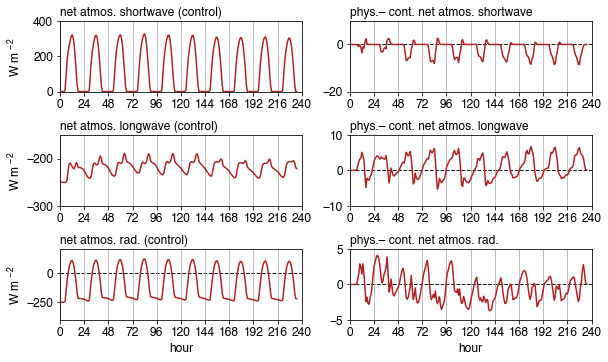

In [30]:
fontsize = 12

fig,axl = mp.subplots(3,2)
fig.set_size_inches(8.5,5)

axl[0,0].plot(xvals-4,net_atm_diffs_400_sw_latlon_subset/(60*60),c='firebrick')
axl[1,0].plot(xvals-4,net_atm_diffs_400_lw_latlon_subset/(60*60),c='firebrick')
#axl[1,0].plot(xvals-4,net_atm_diffs_1000_lw_latlon_subset/(60*60),c='coral')

axl[2,0].plot(xvals-4,(net_atm_diffs_400_sw_latlon_subset+net_atm_diffs_400_lw_latlon_subset)/(60*60),c='firebrick')

axl[0,1].plot(xvals-4,(net_atm_diffs_1000_sw_latlon_subset-net_atm_diffs_400_sw_latlon_subset)/(60*60),c='firebrick')
axl[1,1].plot(xvals-4,(net_atm_diffs_1000_lw_latlon_subset-net_atm_diffs_400_lw_latlon_subset)/(60*60),c='firebrick')
axl[2,1].plot(xvals-4,\
              ((net_atm_diffs_1000_sw_latlon_subset+net_atm_diffs_1000_lw_latlon_subset)-\
               (net_atm_diffs_400_sw_latlon_subset+net_atm_diffs_400_lw_latlon_subset))/(60*60),c='firebrick')

axl[0,0].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
#axl[1,0].axhline(0, lw=1, c='0.1', ls='--')
axl[2,0].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
axl[0,1].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
axl[1,1].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
axl[2,1].axhline(0, lw=1, c='0.1', ls='--',zorder=0)

axl[0,0].set_ylim(0,400)
axl[1,0].set_ylim(-300,-150)
axl[2,0].set_ylim(-400,200)
axl[0,1].set_ylim(-20,10)
axl[1,1].set_ylim(-10,10)
axl[2,1].set_ylim(-5,5)

[ax.tick_params(labelsize=fontsize) for ax in axl.flatten()]
[ax.set_xlim(0,240) for ax in axl.flatten()]
[ax.set_ylabel('W m$^{\,-2}$', fontsize=fontsize) for ax in axl.flatten()[0::2]]
[ax.set_xlabel('hour', fontsize=fontsize) for ax in axl.flatten()[-2:]]
[ax.get_yaxis().set_label_coords(-0.15,0.5) for ax in axl.flatten()]
[ax.set_xticks(numpy.arange(0,241,24)) for ax in axl.flatten()]
[ax.xaxis.grid() for ax in axl.flatten()]
# [ax.set_axisbelow(True) for ax in axl.flatten()]

plot_labels = [\
'net atmos. shortwave (control)',\
'phys.– cont. net atmos. shortwave',\
'net atmos. longwave (control)',\
'phys.– cont. net atmos. longwave',\
'net atmos. rad. (control)',\
'phys.– cont. net atmos. rad.']

[axl.flatten()[i].text(s=plot_labels[i], ha='left',\
        va='bottom',\
        x=0,y=1.03,\
        transform=axl.flatten()[i].transAxes,\
        fontsize=fontsize)\
for i in range(axl.flatten().size)]

fig.tight_layout(h_pad=2)

fig.savefig('radiation_changes_with_control.png',\
           dpi=600, bbox_inches='tight', transparent=True)

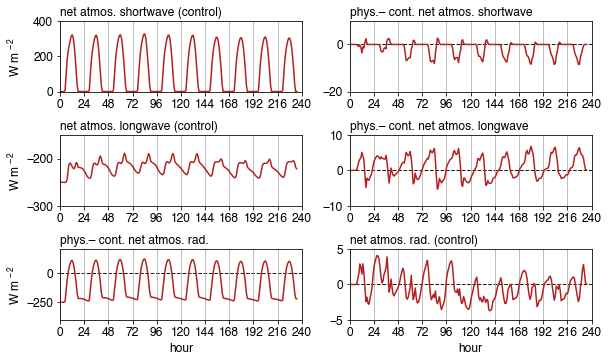

In [31]:
fontsize = 12

fig,axl = mp.subplots(3,2)
fig.set_size_inches(8.5,5)

axl[0,0].plot(xvals-4,net_atm_diffs_400_sw_latlon_subset/(60*60),c='firebrick')
axl[1,0].plot(xvals-4,net_atm_diffs_400_lw_latlon_subset/(60*60),c='firebrick')
#axl[1,0].plot(xvals-4,net_atm_diffs_1000_lw_latlon_subset/(60*60),c='coral')

axl[2,0].plot(xvals-4,(net_atm_diffs_400_sw_latlon_subset+net_atm_diffs_400_lw_latlon_subset)/(60*60),c='firebrick')

axl[0,1].plot(xvals-4,(net_atm_diffs_1000_sw_latlon_subset-net_atm_diffs_400_sw_latlon_subset)/(60*60),c='firebrick')
axl[1,1].plot(xvals-4,(net_atm_diffs_1000_lw_latlon_subset-net_atm_diffs_400_lw_latlon_subset)/(60*60),c='firebrick')
axl[2,1].plot(xvals-4,((net_atm_diffs_1000_sw_latlon_subset+net_atm_diffs_1000_lw_latlon_subset)-(net_atm_diffs_400_sw_latlon_subset+net_atm_diffs_400_lw_latlon_subset))/(60*60),c='firebrick')

axl[0,0].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
#axl[1,0].axhline(0, lw=1, c='0.1', ls='--')
axl[2,0].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
axl[0,1].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
axl[1,1].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
axl[2,1].axhline(0, lw=1, c='0.1', ls='--',zorder=0)

axl[0,0].set_ylim(0,400)
axl[1,0].set_ylim(-300,-150)
axl[2,0].set_ylim(-400,200)
axl[0,1].set_ylim(-20,10)
axl[1,1].set_ylim(-10,10)
axl[2,1].set_ylim(-5,5)

[ax.tick_params(labelsize=fontsize) for ax in axl.flatten()]
[ax.set_xlim(0,240) for ax in axl.flatten()]
[ax.set_ylabel('W m$^{\,-2}$', fontsize=fontsize) for ax in axl.flatten()[0::2]]
[ax.set_xlabel('hour', fontsize=fontsize) for ax in axl.flatten()[-2:]]
[ax.get_yaxis().set_label_coords(-0.15,0.5) for ax in axl.flatten()]
[ax.set_xticks(numpy.arange(0,241,24)) for ax in axl.flatten()]
[ax.xaxis.grid() for ax in axl.flatten()]
# [ax.set_axisbelow(True) for ax in axl.flatten()]

plot_labels = [\
'net atmos. shortwave (control)',\
'phys.– cont. net atmos. shortwave',\
'net atmos. longwave (control)',\
'phys.– cont. net atmos. longwave',\
'phys.– cont. net atmos. rad.',\
'net atmos. rad. (control)' ]

[axl.flatten()[i].text(s=plot_labels[i], ha='left',\
        va='bottom',\
        x=0,y=1.03,\
        transform=axl.flatten()[i].transAxes,\
        fontsize=fontsize)\
for i in range(axl.flatten().size)]

fig.tight_layout(h_pad=2)

fig.savefig('radiation_changes_with_control.png',\
           dpi=600, bbox_inches='tight', transparent=True)

# calculate cloud fraction changes

In [33]:
cldfra_diffs = cldfra_1000-cldfra_400
cldfra_diffs_latlon_subset = numpy.mean(cldfra_diffs.values[:,:,latlon_indices], axis=2)

In [35]:
cape2d_diffs_latlon_mean = numpy.nanmean(cape2d_diffs[:,:,latlon_indices], axis=2)

In [69]:
cape3d_400_latlon_mean = numpy.nanmean(cape3d_400[:,:,:,latlon_indices], axis=3)
cape3d_1000_latlon_mean = numpy.nanmean(cape3d_1000[:,:,:,latlon_indices], axis=3)

cape3d_diffs_latlon_mean = cape3d_1000_latlon_mean - cape3d_400_latlon_mean

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


# plot cloud changes and radiative changes

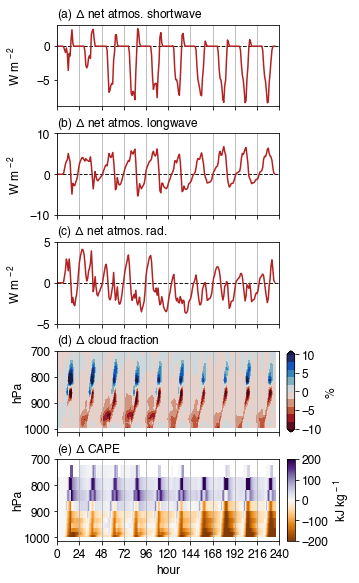

In [34]:
fontsize = 12

fig,axes = mp.subplots(5,1)
fig.set_size_inches(4.25,8)

axes[0].plot(xvals-4,(net_atm_diffs_1000_sw_latlon_subset-net_atm_diffs_400_sw_latlon_subset)/(60*60),c='firebrick')
axes[1].plot(xvals-4,(net_atm_diffs_1000_lw_latlon_subset-net_atm_diffs_400_lw_latlon_subset)/(60*60),c='firebrick')
axes[2].plot(xvals-4,\
            ((net_atm_diffs_1000_sw_latlon_subset+net_atm_diffs_1000_lw_latlon_subset)-\
             (net_atm_diffs_400_sw_latlon_subset+net_atm_diffs_400_lw_latlon_subset))/(60*60),c='firebrick')

levels = numpy.arange(-.1,.11,0.02)*100.
contour_plot = axes[3].contourf(numpy.arange(241)-4,\
                                ptot_latlon_subset_timemean/100.,\
                                cldfra_diffs_latlon_subset.T*100.,\
                                levels=levels, extend='both',\
                                cmap=cmocean.cm.balance_r)

levels = numpy.arange(-.25,.251,0.05)
contour_plot2 = axes[4].pcolormesh(numpy.arange(241)-4,\
                                ptot_latlon_subset_timemean/100.,\
                                cape3d_cape_diffs_latlon_mean.T,\
                                vmin=-200,vmax=200,\
                                #levels=levels, extend='both',\
                                cmap='PuOr')
axes[3].set_ylim(1013.25,700)
axes[4].set_ylim(1013.25,700)

axes[0].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
axes[1].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
axes[2].axhline(0, lw=1, c='0.1', ls='--',zorder=0)

axes[1].set_ylim(-10,10)
axes[2].set_ylim(-5,5)

[ax.tick_params(labelsize=fontsize) for ax in axes.flatten()]
[ax.set_xlim(0,240) for ax in axes.flatten()]
[ax.set_ylabel('W m$^{\,-2}$', fontsize=fontsize) for ax in axes.flatten()[0:3]]
[ax.set_xlabel('hour', fontsize=fontsize) for ax in [axes[-1]]]
[ax.get_yaxis().set_label_coords(-0.15,0.5) for ax in axes.flatten()]
[ax.xaxis.grid() for ax in axes.flatten()]

axes[3].set_ylabel('hPa', fontsize=fontsize)
axes[3].set_yticks([700,800,900,1000])

axes[4].set_ylabel('hPa', fontsize=fontsize)
axes[4].set_yticks([700,800,900,1000])

[ax.set_xticks(numpy.arange(0,241,24)) for ax in axes.flatten()]
[ax.set_xticklabels([]) for ax in axes[0:4]]
# [ax.set_axisbelow(True) for ax in axes.flatten()]

plot_labels = [\
'(a) $\Delta$ net atmos. shortwave',\
'(b) $\Delta$ net atmos. longwave',\
'(c) $\Delta$ net atmos. rad.',\
'(d) $\Delta$ cloud fraction', \
'(e) $\Delta$ CAPE']

[axes.flatten()[i].text(s=plot_labels[i], ha='left',\
        va='bottom',\
        x=0,y=1.03,\
        transform=axes.flatten()[i].transAxes,\
        fontsize=fontsize)\
for i in range(axes.flatten().size)]

fig.tight_layout(h_pad=1.5)

ax4pos = axes[3].get_position()
cbar_ax = fig.add_axes([ax4pos.x1+0.025,ax4pos.y0,0.025,ax4pos.height])
cbar = fig.colorbar(contour_plot, cax=cbar_ax)
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_ticks([-10,-5,0,5,10])
cbar.set_label('%', fontsize=fontsize)

ax5pos = axes[4].get_position()
cbar_ax = fig.add_axes([ax5pos.x1+0.025,ax5pos.y0,0.025,ax5pos.height])
cbar = fig.colorbar(contour_plot2, cax=cbar_ax)
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_ticks([-200,-100,0,100,200])
cbar.set_label('kJ kg$^{\,-1}$', fontsize=fontsize)

fig.savefig('radiation_cloud_cape_changes.png',\
           dpi=600, bbox_inches='tight', transparent=True)

# plot cape and cin background

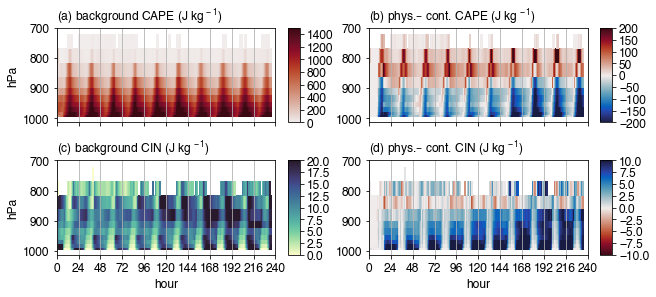

In [129]:
fontsize = 12

fig,axes = mp.subplots(2,2)
fig.set_size_inches(8.5,4)

cp1 = axes[0,0].pcolormesh(numpy.arange(241)-4,\
                         ptot_latlon_subset_timemean/100.,\
                         cape3d_400_latlon_mean[0,:].T,\
                         vmin=0,vmax=1500,\
                         #levels=levels, extend='both',\
                         cmap=cmocean.cm.amp)
axes[0,0].set_ylim(1013.25,700)

cp2 = axes[0,1].pcolormesh(numpy.arange(241)-4,\
                         ptot_latlon_subset_timemean/100.,\
                         cape3d_diffs_latlon_mean[0,:].T,\
                         vmin=-200,vmax=200,\
                         cmap=cmocean.cm.balance)
axes[0,1].set_ylim(1013.25,700)


cp3 = axes[1,0].pcolormesh(numpy.arange(241)-4,\
                         ptot_latlon_subset_timemean/100.,\
                         cape3d_400_latlon_mean[1,:].T,\
                         vmin=0,vmax=20,\
                         #levels=levels, extend='both',\
                         cmap=cmocean.cm.deep)
axes[1,0].set_ylim(1013.25,700)



cp4 = axes[1,1].pcolormesh(numpy.arange(241)-4,\
                         ptot_latlon_subset_timemean/100.,\
                         cape3d_diffs_latlon_mean[1,:].T,\
                         vmin=-10,vmax=10,\
                         cmap=cmocean.cm.balance_r)
axes[1,1].set_ylim(1013.25,700)

[ax.tick_params(labelsize=fontsize) for ax in axes.flatten()]
[ax.set_xlim(0,240) for ax in axes.flatten()]
[ax.set_xlabel('hour', fontsize=fontsize) for ax in [axes[1,0],axes[1,1]]]
#[ax.get_yaxis().set_label_coords(-0.15,0.5) for ax in axes.flatten()]
[ax.xaxis.grid() for ax in axes.flatten()]
[ax.set_xticks(numpy.arange(0,241,24)) for ax in axes.flatten()]
[ax.set_xticklabels([]) for ax in axes.flatten()[0:2]]
[ax.set_ylabel('hPa', fontsize=fontsize) for ax in axes.flatten()[0::2]]
[ax.set_yticks([700,800,900,1000]) for ax in axes.flatten()]

fig.tight_layout(h_pad=3,w_pad=5)

plot_labels = [\
'(a) background CAPE (J kg$^{\,-1}$)',\
'(b) phys.– cont. CAPE (J kg$^{\,-1}$)',\
'(c) background CIN (J kg$^{\,-1}$)',\
'(d) phys.– cont. CIN (J kg$^{\,-1}$)']

[axes.flatten()[i].text(s=plot_labels[i], ha='left',\
        va='bottom',\
        x=0,y=1.02,\
        transform=axes.flatten()[i].transAxes,\
        fontsize=fontsize)\
for i in range(axes.flatten().size)]

cbar_list = [cp1,cp2,cp3,cp4]
pos_list = [ax.get_position() for ax in axes.flatten()]
cbar_ax_list = [fig.add_axes([axpos.x1+0.02,axpos.y0,0.02,axpos.height]) for axpos in pos_list]
#cbar_ax_list += [fig.add_axes([axpos.x0,axpos.y0-.1,axpos.width,0.025]) for axpos in pos_list[2:4]]

cbar_list = [fig.colorbar(cbar_list[i], cax=cbar_ax_list[i], orientation='vertical') for i in range(4)]
[cax.tick_params(labelsize=fontsize) for cax in cbar_ax_list]

fig.savefig('background_and_change_CAPE_CIN.png', dpi=600, bbox_inches='tight', transparent=True)

In [107]:
pos_list[0::2]

[Bbox([[0.09852941176470588, 0.6368055555555554], [0.4879084967320261, 0.9574999999999998]]),
 Bbox([[0.09852941176470588, 0.12722222222222213], [0.4879084967320261, 0.4479166666666665]])]

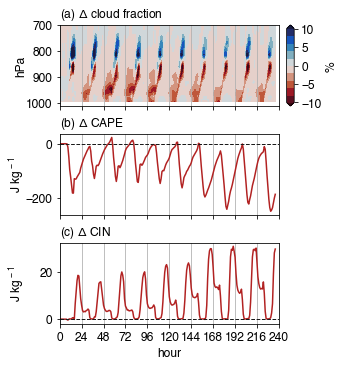

In [412]:
fontsize = 12

fig,axes = mp.subplots(3,1)
fig.set_size_inches(4.25,5)

levels = numpy.arange(-.1,.11,0.02)*100.
contour_plot = axes[0].contourf(numpy.arange(241)-4,\
                                ptot_latlon_subset_timemean/100.,\
                                cldfra_diffs_latlon_subset.T*100.,\
                                levels=levels, extend='both',\
                                cmap=cmocean.cm.balance_r)

axes[1].plot(numpy.arange(241)-4,\
             cape2d_diffs_latlon_mean[0,:], c='firebrick')

axes[2].plot(numpy.arange(241)-4,\
             cape2d_diffs_latlon_mean[1,:], c='firebrick')
# levels = numpy.arange(-.25,.251,0.05)
# contour_plot2 = axes[1].pcolormesh(numpy.arange(241)-4,\
#                                 ptot_latlon_subset_timemean/100.,\
#                                 cape3d_cape_diffs_latlon_mean.T,\
#                                 vmin=-200,vmax=200,\
#                                 #levels=levels, extend='both',\
#                                 cmap='PuOr')
axes[0].set_ylim(1013.25,700)

axes[0].set_ylabel('W m$^{\,-2}$', fontsize=fontsize)
axes[1].set_ylabel('J kg$^{\,-1}$', fontsize=fontsize)
axes[2].set_ylabel('J kg$^{\,-1}$', fontsize=fontsize)

axes[1].axhline(0, lw='1', c='0.1', ls='--')
axes[2].axhline(0, lw='1', c='0.1', ls='--')

[ax.tick_params(labelsize=fontsize) for ax in axes.flatten()]
[ax.set_xlim(0,240) for ax in axes.flatten()]
[ax.set_xlabel('hour', fontsize=fontsize) for ax in [axes[-1]]]
[ax.get_yaxis().set_label_coords(-0.15,0.5) for ax in axes.flatten()]
[ax.xaxis.grid() for ax in axes.flatten()]

axes[0].set_ylabel('hPa', fontsize=fontsize)
axes[0].set_yticks([700,800,900,1000])

# axes[1].set_ylabel('hPa', fontsize=fontsize)
# axes[1].set_yticks([700,800,900,1000])

[ax.set_xticks(numpy.arange(0,241,24)) for ax in axes.flatten()]
[ax.set_xticklabels([]) for ax in axes[0:2]]
# [ax.set_axisbelow(True) for ax in axes.flatten()]

plot_labels = [\
'(a) $\Delta$ cloud fraction', \
'(b) $\Delta$ CAPE', \
'(c) $\Delta$ CIN']

[axes.flatten()[i].text(s=plot_labels[i], ha='left',\
        va='bottom',\
        x=0,y=1.03,\
        transform=axes.flatten()[i].transAxes,\
        fontsize=fontsize)\
for i in range(axes.flatten().size)]

fig.tight_layout(h_pad=2)

ax1pos = axes[0].get_position()
cbar_ax = fig.add_axes([ax1pos.x1+0.025,ax1pos.y0,0.025,ax1pos.height])
cbar = fig.colorbar(contour_plot, cax=cbar_ax)
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_ticks([-10,-5,0,5,10])
cbar.set_label('%', fontsize=fontsize)

# ax2pos = axes[1].get_position()
# cbar_ax = fig.add_axes([ax2pos.x1+0.025,ax2pos.y0,0.025,ax2pos.height])
# cbar = fig.colorbar(contour_plot2, cax=cbar_ax)
# cbar_ax.tick_params(labelsize=fontsize)
# cbar.set_ticks([-200,-100,0,100,200])
# cbar.set_label('kJ kg$^{\,-1}$', fontsize=fontsize)

fig.savefig('cloud_cape_cin_timeseries_changes.png',\
           dpi=600, bbox_inches='tight', transparent=True)

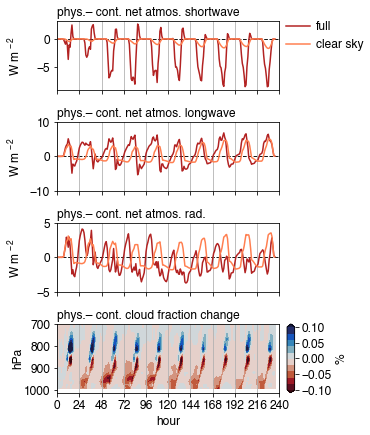

In [262]:
fontsize = 12

fig,axes = mp.subplots(4,1)
fig.set_size_inches(4.25,6)

axes[0].plot(xvals-4,(net_atm_diffs_1000_sw_latlon_subset-net_atm_diffs_400_sw_latlon_subset)/(60*60),c='firebrick',label='full')
axes[1].plot(xvals-4,(net_atm_diffs_1000_lw_latlon_subset-net_atm_diffs_400_lw_latlon_subset)/(60*60),c='firebrick')
axes[2].plot(xvals-4,\
            ((net_atm_diffs_1000_sw_latlon_subset+net_atm_diffs_1000_lw_latlon_subset)-\
             (net_atm_diffs_400_sw_latlon_subset+net_atm_diffs_400_lw_latlon_subset))/(60*60),c='firebrick')


axes[0].plot(xvals-4,(net_atm_diffs_1000_swc_latlon_subset-net_atm_diffs_400_swc_latlon_subset)/(60*60),c='coral',label='clear sky')
axes[1].plot(xvals-4,(net_atm_diffs_1000_lwc_latlon_subset-net_atm_diffs_400_lwc_latlon_subset)/(60*60),c='coral')
axes[2].plot(xvals-4,\
            ((net_atm_diffs_1000_swc_latlon_subset+net_atm_diffs_1000_lwc_latlon_subset)-\
             (net_atm_diffs_400_swc_latlon_subset+net_atm_diffs_400_lwc_latlon_subset))/(60*60),c='coral')

contour_plot = axes[3].contourf(numpy.arange(241)-4,\
                                ptot_latlon_subset_timemean/100.,\
                                cldfra_diffs_latlon_subset.T,\
                                levels=levels, extend='both',\
                                cmap=cmocean.cm.balance_r)

axes[3].set_ylim(1013.25,700)

axes[0].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
axes[1].axhline(0, lw=1, c='0.1', ls='--',zorder=0)
axes[2].axhline(0, lw=1, c='0.1', ls='--',zorder=0)

axes[1].set_ylim(-10,10)
axes[2].set_ylim(-5,5)

[ax.tick_params(labelsize=fontsize) for ax in axes.flatten()]
[ax.set_xlim(0,240) for ax in axes.flatten()]
[ax.set_ylabel('W m$^{\,-2}$', fontsize=fontsize) for ax in axes.flatten()[0:3]]
[ax.set_xlabel('hour', fontsize=fontsize) for ax in [axes[-1]]]
[ax.get_yaxis().set_label_coords(-0.15,0.5) for ax in axes.flatten()]
[ax.xaxis.grid() for ax in axes.flatten()]

axes[3].set_ylabel('hPa', fontsize=fontsize)
axes[3].set_yticks([700,800,900,1000])

[ax.set_xticks(numpy.arange(0,241,24)) for ax in axes.flatten()]
[ax.set_xticklabels([]) for ax in axes[0:3]]
# [ax.set_axisbelow(True) for ax in axes.flatten()]

plot_labels = [\
'phys.– cont. net atmos. shortwave',\
'phys.– cont. net atmos. longwave',\
'phys.– cont. net atmos. rad.',\
'phys.– cont. cloud fraction change' ]

[axes.flatten()[i].text(s=plot_labels[i], ha='left',\
        va='bottom',\
        x=0,y=1.03,\
        transform=axes.flatten()[i].transAxes,\
        fontsize=fontsize)\
for i in range(axes.flatten().size)]

fig.tight_layout(h_pad=2)

ax4pos = axes[3].get_position()
cbar_ax = fig.add_axes([ax4pos.x1+0.025,ax4pos.y0,0.025,ax4pos.height])
cbar = fig.colorbar(contour_plot, cax=cbar_ax)
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_ticks([-.1,-0.05,0,0.05,0.1])
cbar.set_label('%', fontsize=fontsize)

handles,labels=axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, fontsize=fontsize, scatterpoints=1, ncol=1, \
               bbox_to_anchor=(1.03,1.0), bbox_transform=axes[0].transAxes, \
               loc='upper left', borderaxespad=0,\
               fancybox=False, edgecolor='0', framealpha=0, borderpad=0., \
               handletextpad=0.5)

fig.savefig('radiation_AND_CLOUD_changes_with_control_full_and_clearsky.png',\
           dpi=600, bbox_inches='tight', transparent=True)

# get time data

In [46]:
time_datetimes = pandas.to_datetime([i.decode('utf-8') for i in time], format = '%Y-%m-%d_%H:%M:%S')

In [47]:
skip_time = 24
n_intervals = 8
hour_strings = ['06','09','12','15','18','21','00','03']
hour_strings_local = ['02', '05', '08', '11', '14', '17','20', '23']

times_00 = [t.hour in [23,0,1] for t in time_datetimes[skip_time:]]
times_03 = [t.hour in [2,3,4] for t in time_datetimes[skip_time:]]
times_06 = [t.hour in [5,6,7] for t in time_datetimes[skip_time:]]
times_09 = [t.hour in [8,9,10] for t in time_datetimes[skip_time:]]
times_12 = [t.hour in [11,12,13] for t in time_datetimes[skip_time:]]
times_15 = [t.hour in [14,15,16] for t in time_datetimes[skip_time:]]
times_18 = [t.hour in [17,18,19] for t in time_datetimes[skip_time:]]
times_21 = [t.hour in [20,21,22] for t in time_datetimes[skip_time:]]

# lat indices

In [14]:
lat_hi = 10.
lat_lo = -10.

# subset between lat_hi and lat_lo
lat_indices = (xlat<=lat_hi)&(xlat>=lat_lo)

In [ ]:
lon_lo = 290-360
lon_hi = 320-360
lon_indices = (xlong[0,:]<lon_lo)|(xlong[0,:]>lon_hi)

# cldfra

# geopotential

In [31]:
geopot_400_landmask = numpy.copy(geopot_400)
geopot_400_landmask[:,:,landmask==1]=numpy.nan

In [32]:
geopot_400_lat_subset = geopot_400[:,:,lat_indices[:,0],:]
geopot_400_lat_mean = numpy.nanmean(geopot_400_lat_subset, axis=2)

# net_bottom

In [109]:
net_bottom_diffs = net_bottom_diffs_1000-net_bottom_diffs_400

In [110]:
net_bottom_diffs_landmask = numpy.copy(net_bottom_diffs)
net_bottom_diffs_landmask[:,landmask==0]=numpy.nan

net_bottom_400_landmask = numpy.copy(net_bottom_400)
net_bottom_400_landmask[:,landmask==0]=numpy.nan

net_bottom_1000_landmask = numpy.copy(net_bottom_1000)
net_bottom_1000_landmask[:,landmask==0]=numpy.nan

In [111]:
net_bottom_diffs_lat_subset = net_bottom_diffs_landmask[:,lat_indices[:,0],:]
net_bottom_400_lat_subset = net_bottom_400_landmask[:,lat_indices[:,0],:]
net_bottom_1000_lat_subset = net_bottom_1000_landmask[:,lat_indices[:,0],:]

net_bottom_400_lat_subset[:,:,lon_indices]=numpy.nan
net_bottom_1000_lat_subset[:,:,lon_indices]=numpy.nan

In [112]:
net_bottom_diffs_lat_mean = numpy.nanmean(net_bottom_diffs_lat_subset, axis=1)
net_bottom_400_lat_mean = numpy.nanmean(net_bottom_400_lat_subset, axis=1)
net_bottom_1000_lat_mean = numpy.nanmean(net_bottom_1000_lat_subset, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


# fira

In [16]:
fira_diffs = fira_1000.values-fira_400.values

In [17]:
fira_diffs_landmask = numpy.copy(fira_diffs)
fira_diffs_landmask[:,landmask==0]=numpy.nan

fira_400_landmask = numpy.copy(fira_400)
fira_400_landmask[:,landmask==0]=numpy.nan

fira_1000_landmask = numpy.copy(fira_1000)
fira_1000_landmask[:,landmask==0]=numpy.nan

In [26]:
fira_diffs_lat_subset = fira_diffs_landmask[:,lat_indices[:,0],:]
fira_400_lat_subset = fira_400_landmask[:,lat_indices[:,0],:]
fira_1000_lat_subset = fira_1000_landmask[:,lat_indices[:,0],:]

fira_400_lat_subset[:,:,lon_indices]=numpy.nan
fira_1000_lat_subset[:,:,lon_indices]=numpy.nan

In [27]:
fira_diffs_lat_mean = numpy.nanmean(fira_diffs_lat_subset, axis=1)
fira_400_lat_mean = numpy.nanmean(fira_400_lat_subset, axis=1)
fira_1000_lat_mean = numpy.nanmean(fira_1000_lat_subset, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


# fsa

In [20]:
fsa_diffs = fsa_1000.values-fsa_400.values

In [21]:
fsa_diffs_landmask = numpy.copy(fsa_diffs)
fsa_diffs_landmask[:,landmask==0]=numpy.nan

fsa_400_landmask = numpy.copy(fsa_400)
fsa_400_landmask[:,landmask==0]=numpy.nan

fsa_1000_landmask = numpy.copy(fsa_1000)
fsa_1000_landmask[:,landmask==0]=numpy.nan

In [33]:
fsa_diffs_lat_subset = fsa_diffs_landmask[:,lat_indices[:,0],:]
fsa_400_lat_subset = fsa_400_landmask[:,lat_indices[:,0],:]
fsa_1000_lat_subset = fsa_1000_landmask[:,lat_indices[:,0],:]

fsa_400_lat_subset[:,:,lon_indices]=numpy.nan
fsa_1000_lat_subset[:,:,lon_indices]=numpy.nan

In [34]:
fsa_diffs_lat_mean = numpy.nanmean(fsa_diffs_lat_subset, axis=1)
fsa_400_lat_mean = numpy.nanmean(fsa_400_lat_subset, axis=1)
fsa_1000_lat_mean = numpy.nanmean(fsa_1000_lat_subset, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


# glw

In [74]:
glw_diffs = glw_1000.values-glw_400.values

In [75]:
glw_diffs_landmask = numpy.copy(glw_diffs)
glw_diffs_landmask[:,landmask==0]=numpy.nan

glw_400_landmask = numpy.copy(glw_400)
glw_400_landmask[:,landmask==0]=numpy.nan

glw_1000_landmask = numpy.copy(glw_1000)
glw_1000_landmask[:,landmask==0]=numpy.nan

In [76]:
glw_diffs_lat_subset = glw_diffs_landmask[:,lat_indices[:,0],:]
glw_400_lat_subset = glw_400_landmask[:,lat_indices[:,0],:]
glw_1000_lat_subset = glw_1000_landmask[:,lat_indices[:,0],:]

glw_400_lat_subset[:,:,lon_indices]=numpy.nan
glw_1000_lat_subset[:,:,lon_indices]=numpy.nan

In [77]:
glw_diffs_lat_mean = numpy.nanmean(glw_diffs_lat_subset, axis=1)
glw_400_lat_mean = numpy.nanmean(glw_400_lat_subset, axis=1)
glw_1000_lat_mean = numpy.nanmean(glw_1000_lat_subset, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


# swdown

In [78]:
swdown_diffs = swdown_1000.values-swdown_400.values

In [79]:
swdown_diffs_landmask = numpy.copy(swdown_diffs)
swdown_diffs_landmask[:,landmask==0]=numpy.nan

swdown_400_landmask = numpy.copy(swdown_400)
swdown_400_landmask[:,landmask==0]=numpy.nan

swdown_1000_landmask = numpy.copy(swdown_1000)
swdown_1000_landmask[:,landmask==0]=numpy.nan

In [80]:
swdown_diffs_lat_subset = swdown_diffs_landmask[:,lat_indices[:,0],:]
swdown_400_lat_subset = swdown_400_landmask[:,lat_indices[:,0],:]
swdown_1000_lat_subset = swdown_1000_landmask[:,lat_indices[:,0],:]

swdown_400_lat_subset[:,:,lon_indices]=numpy.nan
swdown_1000_lat_subset[:,:,lon_indices]=numpy.nan

In [81]:
swdown_diffs_lat_mean = numpy.nanmean(swdown_diffs_lat_subset, axis=1)
swdown_400_lat_mean = numpy.nanmean(swdown_400_lat_subset, axis=1)
swdown_1000_lat_mean = numpy.nanmean(swdown_1000_lat_subset, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


# 3 hourly means of net_bottom

In [113]:
# calculate 3 hourly means for 400
net_bottom_400_t00mean = numpy.mean(net_bottom_400_lat_mean[skip_time:][times_00,:], axis=0)
net_bottom_400_t03mean = numpy.mean(net_bottom_400_lat_mean[skip_time:][times_03,:], axis=0)
net_bottom_400_t06mean = numpy.mean(net_bottom_400_lat_mean[skip_time:][times_06,:], axis=0)
net_bottom_400_t09mean = numpy.mean(net_bottom_400_lat_mean[skip_time:][times_09,:], axis=0)
net_bottom_400_t12mean = numpy.mean(net_bottom_400_lat_mean[skip_time:][times_12,:], axis=0)
net_bottom_400_t15mean = numpy.mean(net_bottom_400_lat_mean[skip_time:][times_15,:], axis=0)
net_bottom_400_t18mean = numpy.mean(net_bottom_400_lat_mean[skip_time:][times_18,:], axis=0)
net_bottom_400_t21mean = numpy.mean(net_bottom_400_lat_mean[skip_time:][times_21,:], axis=0)

net_bottom_1000_t00mean = numpy.nanmean(net_bottom_1000_lat_mean[skip_time:][times_00,:], axis=0)
net_bottom_1000_t03mean = numpy.nanmean(net_bottom_1000_lat_mean[skip_time:][times_03,:], axis=0)
net_bottom_1000_t06mean = numpy.nanmean(net_bottom_1000_lat_mean[skip_time:][times_06,:], axis=0)
net_bottom_1000_t09mean = numpy.nanmean(net_bottom_1000_lat_mean[skip_time:][times_09,:], axis=0)
net_bottom_1000_t12mean = numpy.nanmean(net_bottom_1000_lat_mean[skip_time:][times_12,:], axis=0)
net_bottom_1000_t15mean = numpy.nanmean(net_bottom_1000_lat_mean[skip_time:][times_15,:], axis=0)
net_bottom_1000_t18mean = numpy.nanmean(net_bottom_1000_lat_mean[skip_time:][times_18,:], axis=0)
net_bottom_1000_t21mean = numpy.nanmean(net_bottom_1000_lat_mean[skip_time:][times_21,:], axis=0)

net_bottom_400_array = numpy.array([net_bottom_400_t06mean, net_bottom_400_t09mean, net_bottom_400_t12mean, net_bottom_400_t15mean, net_bottom_400_t18mean, net_bottom_400_t21mean, net_bottom_400_t00mean, net_bottom_400_t03mean])
net_bottom_1000_array = numpy.array([net_bottom_1000_t06mean, net_bottom_1000_t09mean, net_bottom_1000_t12mean, net_bottom_1000_t15mean, net_bottom_1000_t18mean, net_bottom_1000_t21mean, net_bottom_1000_t00mean, net_bottom_1000_t03mean])


/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWar

In [114]:
# calculate 3 hourly means for 400
net_bottom_diffs_t00mean = numpy.nanmean(net_bottom_diffs_lat_mean[skip_time:,:][times_00,:], axis=0)
net_bottom_diffs_t03mean = numpy.nanmean(net_bottom_diffs_lat_mean[skip_time:,:][times_03,:], axis=0)
net_bottom_diffs_t06mean = numpy.nanmean(net_bottom_diffs_lat_mean[skip_time:,:][times_06,:], axis=0)
net_bottom_diffs_t09mean = numpy.nanmean(net_bottom_diffs_lat_mean[skip_time:,:][times_09,:], axis=0)
net_bottom_diffs_t12mean = numpy.nanmean(net_bottom_diffs_lat_mean[skip_time:,:][times_12,:], axis=0)
net_bottom_diffs_t15mean = numpy.nanmean(net_bottom_diffs_lat_mean[skip_time:,:][times_15,:], axis=0)
net_bottom_diffs_t18mean = numpy.nanmean(net_bottom_diffs_lat_mean[skip_time:,:][times_18,:], axis=0)
net_bottom_diffs_t21mean = numpy.nanmean(net_bottom_diffs_lat_mean[skip_time:,:][times_21,:], axis=0)

net_bottom_diffs_array = numpy.array([net_bottom_diffs_t06mean, net_bottom_diffs_t09mean, net_bottom_diffs_t12mean, net_bottom_diffs_t15mean, net_bottom_diffs_t18mean, net_bottom_diffs_t21mean, net_bottom_diffs_t00mean, net_bottom_diffs_t03mean])


/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/ex

# 3 hourly means of fira

In [37]:
# calculate 3 hourly means for 400
fira_400_t00mean = numpy.mean(fira_400_lat_mean[skip_time:][times_00,:], axis=0)
fira_400_t03mean = numpy.mean(fira_400_lat_mean[skip_time:][times_03,:], axis=0)
fira_400_t06mean = numpy.mean(fira_400_lat_mean[skip_time:][times_06,:], axis=0)
fira_400_t09mean = numpy.mean(fira_400_lat_mean[skip_time:][times_09,:], axis=0)
fira_400_t12mean = numpy.mean(fira_400_lat_mean[skip_time:][times_12,:], axis=0)
fira_400_t15mean = numpy.mean(fira_400_lat_mean[skip_time:][times_15,:], axis=0)
fira_400_t18mean = numpy.mean(fira_400_lat_mean[skip_time:][times_18,:], axis=0)
fira_400_t21mean = numpy.mean(fira_400_lat_mean[skip_time:][times_21,:], axis=0)

fira_1000_t00mean = numpy.mean(fira_1000_lat_mean[skip_time:][times_00,:], axis=0)
fira_1000_t03mean = numpy.mean(fira_1000_lat_mean[skip_time:][times_03,:], axis=0)
fira_1000_t06mean = numpy.mean(fira_1000_lat_mean[skip_time:][times_06,:], axis=0)
fira_1000_t09mean = numpy.mean(fira_1000_lat_mean[skip_time:][times_09,:], axis=0)
fira_1000_t12mean = numpy.mean(fira_1000_lat_mean[skip_time:][times_12,:], axis=0)
fira_1000_t15mean = numpy.mean(fira_1000_lat_mean[skip_time:][times_15,:], axis=0)
fira_1000_t18mean = numpy.mean(fira_1000_lat_mean[skip_time:][times_18,:], axis=0)
fira_1000_t21mean = numpy.mean(fira_1000_lat_mean[skip_time:][times_21,:], axis=0)

fira_400_array = numpy.array([fira_400_t06mean, fira_400_t09mean, fira_400_t12mean, fira_400_t15mean, fira_400_t18mean, fira_400_t21mean, fira_400_t00mean, fira_400_t03mean])
fira_1000_array = numpy.array([fira_1000_t06mean, fira_1000_t09mean, fira_1000_t12mean, fira_1000_t15mean, fira_1000_t18mean, fira_1000_t21mean, fira_1000_t00mean, fira_1000_t03mean])


In [59]:
# calculate 3 hourly means for 400
fira_diffs_t00mean = numpy.mean(fira_diffs_lat_mean[skip_time:,:][times_00,:], axis=0)
fira_diffs_t03mean = numpy.mean(fira_diffs_lat_mean[skip_time:,:][times_03,:], axis=0)
fira_diffs_t06mean = numpy.mean(fira_diffs_lat_mean[skip_time:,:][times_06,:], axis=0)
fira_diffs_t09mean = numpy.mean(fira_diffs_lat_mean[skip_time:,:][times_09,:], axis=0)
fira_diffs_t12mean = numpy.mean(fira_diffs_lat_mean[skip_time:,:][times_12,:], axis=0)
fira_diffs_t15mean = numpy.mean(fira_diffs_lat_mean[skip_time:,:][times_15,:], axis=0)
fira_diffs_t18mean = numpy.mean(fira_diffs_lat_mean[skip_time:,:][times_18,:], axis=0)
fira_diffs_t21mean = numpy.mean(fira_diffs_lat_mean[skip_time:,:][times_21,:], axis=0)

fira_diffs_array = numpy.array([fira_diffs_t06mean, fira_diffs_t09mean, fira_diffs_t12mean, fira_diffs_t15mean, fira_diffs_t18mean, fira_diffs_t21mean, fira_diffs_t00mean, fira_diffs_t03mean])


# 3 hourly means of fsa

In [46]:
# calculate 3 hourly means for 400
fsa_400_t00mean = numpy.mean(fsa_400_lat_mean[skip_time:][times_00,:], axis=0)
fsa_400_t03mean = numpy.mean(fsa_400_lat_mean[skip_time:][times_03,:], axis=0)
fsa_400_t06mean = numpy.mean(fsa_400_lat_mean[skip_time:][times_06,:], axis=0)
fsa_400_t09mean = numpy.mean(fsa_400_lat_mean[skip_time:][times_09,:], axis=0)
fsa_400_t12mean = numpy.mean(fsa_400_lat_mean[skip_time:][times_12,:], axis=0)
fsa_400_t15mean = numpy.mean(fsa_400_lat_mean[skip_time:][times_15,:], axis=0)
fsa_400_t18mean = numpy.mean(fsa_400_lat_mean[skip_time:][times_18,:], axis=0)
fsa_400_t21mean = numpy.mean(fsa_400_lat_mean[skip_time:][times_21,:], axis=0)

fsa_1000_t00mean = numpy.mean(fsa_1000_lat_mean[skip_time:][times_00,:], axis=0)
fsa_1000_t03mean = numpy.mean(fsa_1000_lat_mean[skip_time:][times_03,:], axis=0)
fsa_1000_t06mean = numpy.mean(fsa_1000_lat_mean[skip_time:][times_06,:], axis=0)
fsa_1000_t09mean = numpy.mean(fsa_1000_lat_mean[skip_time:][times_09,:], axis=0)
fsa_1000_t12mean = numpy.mean(fsa_1000_lat_mean[skip_time:][times_12,:], axis=0)
fsa_1000_t15mean = numpy.mean(fsa_1000_lat_mean[skip_time:][times_15,:], axis=0)
fsa_1000_t18mean = numpy.mean(fsa_1000_lat_mean[skip_time:][times_18,:], axis=0)
fsa_1000_t21mean = numpy.mean(fsa_1000_lat_mean[skip_time:][times_21,:], axis=0)

fsa_400_array = numpy.array([fsa_400_t06mean, fsa_400_t09mean, fsa_400_t12mean, fsa_400_t15mean, fsa_400_t18mean, fsa_400_t21mean, fsa_400_t00mean, fsa_400_t03mean])
fsa_1000_array = numpy.array([fsa_1000_t06mean, fsa_1000_t09mean, fsa_1000_t12mean, fsa_1000_t15mean, fsa_1000_t18mean, fsa_1000_t21mean, fsa_1000_t00mean, fsa_1000_t03mean])

In [58]:
# calculate 3 hourly means for 400
fsa_diffs_t00mean = numpy.mean(fsa_diffs_lat_mean[skip_time:,:][times_00,:], axis=0)
fsa_diffs_t03mean = numpy.mean(fsa_diffs_lat_mean[skip_time:,:][times_03,:], axis=0)
fsa_diffs_t06mean = numpy.mean(fsa_diffs_lat_mean[skip_time:,:][times_06,:], axis=0)
fsa_diffs_t09mean = numpy.mean(fsa_diffs_lat_mean[skip_time:,:][times_09,:], axis=0)
fsa_diffs_t12mean = numpy.mean(fsa_diffs_lat_mean[skip_time:,:][times_12,:], axis=0)
fsa_diffs_t15mean = numpy.mean(fsa_diffs_lat_mean[skip_time:,:][times_15,:], axis=0)
fsa_diffs_t18mean = numpy.mean(fsa_diffs_lat_mean[skip_time:,:][times_18,:], axis=0)
fsa_diffs_t21mean = numpy.mean(fsa_diffs_lat_mean[skip_time:,:][times_21,:], axis=0)

fsa_diffs_array = numpy.array([fsa_diffs_t06mean, fsa_diffs_t09mean, fsa_diffs_t12mean, fsa_diffs_t15mean, fsa_diffs_t18mean, fsa_diffs_t21mean, fsa_diffs_t00mean, fsa_diffs_t03mean])


# 3 hourly means of glw

In [82]:
# calculate 3 hourly means for 400
glw_400_t00mean = numpy.mean(glw_400_lat_mean[skip_time:][times_00,:], axis=0)
glw_400_t03mean = numpy.mean(glw_400_lat_mean[skip_time:][times_03,:], axis=0)
glw_400_t06mean = numpy.mean(glw_400_lat_mean[skip_time:][times_06,:], axis=0)
glw_400_t09mean = numpy.mean(glw_400_lat_mean[skip_time:][times_09,:], axis=0)
glw_400_t12mean = numpy.mean(glw_400_lat_mean[skip_time:][times_12,:], axis=0)
glw_400_t15mean = numpy.mean(glw_400_lat_mean[skip_time:][times_15,:], axis=0)
glw_400_t18mean = numpy.mean(glw_400_lat_mean[skip_time:][times_18,:], axis=0)
glw_400_t21mean = numpy.mean(glw_400_lat_mean[skip_time:][times_21,:], axis=0)

glw_1000_t00mean = numpy.mean(glw_1000_lat_mean[skip_time:][times_00,:], axis=0)
glw_1000_t03mean = numpy.mean(glw_1000_lat_mean[skip_time:][times_03,:], axis=0)
glw_1000_t06mean = numpy.mean(glw_1000_lat_mean[skip_time:][times_06,:], axis=0)
glw_1000_t09mean = numpy.mean(glw_1000_lat_mean[skip_time:][times_09,:], axis=0)
glw_1000_t12mean = numpy.mean(glw_1000_lat_mean[skip_time:][times_12,:], axis=0)
glw_1000_t15mean = numpy.mean(glw_1000_lat_mean[skip_time:][times_15,:], axis=0)
glw_1000_t18mean = numpy.mean(glw_1000_lat_mean[skip_time:][times_18,:], axis=0)
glw_1000_t21mean = numpy.mean(glw_1000_lat_mean[skip_time:][times_21,:], axis=0)

glw_400_array = numpy.array([glw_400_t06mean, glw_400_t09mean, glw_400_t12mean, glw_400_t15mean, glw_400_t18mean, glw_400_t21mean, glw_400_t00mean, glw_400_t03mean])
glw_1000_array = numpy.array([glw_1000_t06mean, glw_1000_t09mean, glw_1000_t12mean, glw_1000_t15mean, glw_1000_t18mean, glw_1000_t21mean, glw_1000_t00mean, glw_1000_t03mean])


In [83]:
# calculate 3 hourly means for 400
glw_diffs_t00mean = numpy.mean(glw_diffs_lat_mean[skip_time:,:][times_00,:], axis=0)
glw_diffs_t03mean = numpy.mean(glw_diffs_lat_mean[skip_time:,:][times_03,:], axis=0)
glw_diffs_t06mean = numpy.mean(glw_diffs_lat_mean[skip_time:,:][times_06,:], axis=0)
glw_diffs_t09mean = numpy.mean(glw_diffs_lat_mean[skip_time:,:][times_09,:], axis=0)
glw_diffs_t12mean = numpy.mean(glw_diffs_lat_mean[skip_time:,:][times_12,:], axis=0)
glw_diffs_t15mean = numpy.mean(glw_diffs_lat_mean[skip_time:,:][times_15,:], axis=0)
glw_diffs_t18mean = numpy.mean(glw_diffs_lat_mean[skip_time:,:][times_18,:], axis=0)
glw_diffs_t21mean = numpy.mean(glw_diffs_lat_mean[skip_time:,:][times_21,:], axis=0)

glw_diffs_array = numpy.array([glw_diffs_t06mean, glw_diffs_t09mean, glw_diffs_t12mean, glw_diffs_t15mean, glw_diffs_t18mean, glw_diffs_t21mean, glw_diffs_t00mean, glw_diffs_t03mean])


# 3 hourly means of swdown

In [84]:
# calculate 3 hourly means for 400
swdown_400_t00mean = numpy.mean(swdown_400_lat_mean[skip_time:][times_00,:], axis=0)
swdown_400_t03mean = numpy.mean(swdown_400_lat_mean[skip_time:][times_03,:], axis=0)
swdown_400_t06mean = numpy.mean(swdown_400_lat_mean[skip_time:][times_06,:], axis=0)
swdown_400_t09mean = numpy.mean(swdown_400_lat_mean[skip_time:][times_09,:], axis=0)
swdown_400_t12mean = numpy.mean(swdown_400_lat_mean[skip_time:][times_12,:], axis=0)
swdown_400_t15mean = numpy.mean(swdown_400_lat_mean[skip_time:][times_15,:], axis=0)
swdown_400_t18mean = numpy.mean(swdown_400_lat_mean[skip_time:][times_18,:], axis=0)
swdown_400_t21mean = numpy.mean(swdown_400_lat_mean[skip_time:][times_21,:], axis=0)

swdown_1000_t00mean = numpy.mean(swdown_1000_lat_mean[skip_time:][times_00,:], axis=0)
swdown_1000_t03mean = numpy.mean(swdown_1000_lat_mean[skip_time:][times_03,:], axis=0)
swdown_1000_t06mean = numpy.mean(swdown_1000_lat_mean[skip_time:][times_06,:], axis=0)
swdown_1000_t09mean = numpy.mean(swdown_1000_lat_mean[skip_time:][times_09,:], axis=0)
swdown_1000_t12mean = numpy.mean(swdown_1000_lat_mean[skip_time:][times_12,:], axis=0)
swdown_1000_t15mean = numpy.mean(swdown_1000_lat_mean[skip_time:][times_15,:], axis=0)
swdown_1000_t18mean = numpy.mean(swdown_1000_lat_mean[skip_time:][times_18,:], axis=0)
swdown_1000_t21mean = numpy.mean(swdown_1000_lat_mean[skip_time:][times_21,:], axis=0)

swdown_400_array = numpy.array([swdown_400_t06mean, swdown_400_t09mean, swdown_400_t12mean, swdown_400_t15mean, swdown_400_t18mean, swdown_400_t21mean, swdown_400_t00mean, swdown_400_t03mean])
swdown_1000_array = numpy.array([swdown_1000_t06mean, swdown_1000_t09mean, swdown_1000_t12mean, swdown_1000_t15mean, swdown_1000_t18mean, swdown_1000_t21mean, swdown_1000_t00mean, swdown_1000_t03mean])


In [85]:
# calculate 3 hourly means for 400
swdown_diffs_t00mean = numpy.mean(swdown_diffs_lat_mean[skip_time:,:][times_00,:], axis=0)
swdown_diffs_t03mean = numpy.mean(swdown_diffs_lat_mean[skip_time:,:][times_03,:], axis=0)
swdown_diffs_t06mean = numpy.mean(swdown_diffs_lat_mean[skip_time:,:][times_06,:], axis=0)
swdown_diffs_t09mean = numpy.mean(swdown_diffs_lat_mean[skip_time:,:][times_09,:], axis=0)
swdown_diffs_t12mean = numpy.mean(swdown_diffs_lat_mean[skip_time:,:][times_12,:], axis=0)
swdown_diffs_t15mean = numpy.mean(swdown_diffs_lat_mean[skip_time:,:][times_15,:], axis=0)
swdown_diffs_t18mean = numpy.mean(swdown_diffs_lat_mean[skip_time:,:][times_18,:], axis=0)
swdown_diffs_t21mean = numpy.mean(swdown_diffs_lat_mean[skip_time:,:][times_21,:], axis=0)

swdown_diffs_array = numpy.array([swdown_diffs_t06mean, swdown_diffs_t09mean, swdown_diffs_t12mean, swdown_diffs_t15mean, swdown_diffs_t18mean, swdown_diffs_t21mean, swdown_diffs_t00mean, swdown_diffs_t03mean])


## create grid

In [39]:
xx,zz=numpy.meshgrid(xlong[0,:],geopot_400_lat_mean[0,:,:].mean(axis=1)/10000.)

# plot fira minus fsa

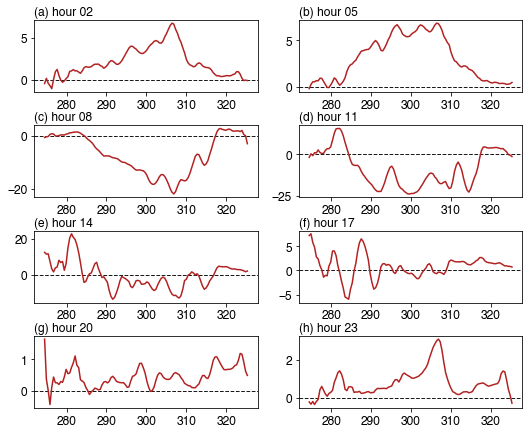

In [119]:
#fig,ax_array = mp.subplots(4,2)
#fig.set_size_inches(7.5,6)
fontsize=12

fig = mp.figure(figsize=(7.5,6))

ax_list = []
for t in range(8):
    ax=fig.add_subplot(4,2,t+1)
    radiation_smoothed = pandas.Series(fira_diffs_array[t]-fsa_diffs_array[t]).rolling(window=3, center=True, min_periods=1).mean()
    ax.plot(xx[0,:]+360., radiation_smoothed, c='firebrick')
    ax.text(s='('+string.ascii_lowercase[t]+') hour '+hour_strings_local[t], x=0, y=1.02,\
            transform=ax.transAxes,fontsize=fontsize,ha='left',va='bottom')
    ax.tick_params(labelsize=fontsize)
    ax_list.append(ax)
    ax.axhline(0, lw=1, c='0.1', ls='--', zorder=0)
fig.tight_layout()

fig.savefig('net_radiation_atmosphere_3hour.png', dpi=600, bbox_inches='tight', transparent=True)

# plot swdown minus glw

# plot net bottom

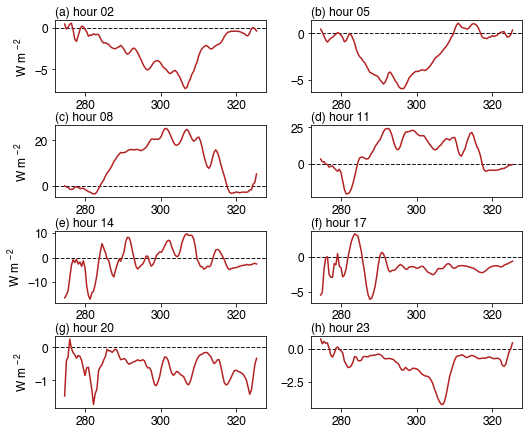

In [118]:
#fig,ax_array = mp.subplots(4,2)
#fig.set_size_inches(7.5,6)
fontsize=12

fig = mp.figure(figsize=(7.5,6))

ax_list = []
for t in range(8):
    ax=fig.add_subplot(4,2,t+1)
    radiation_smoothed = pandas.Series(net_bottom_diffs_array[t]).rolling(window=3, center=True, min_periods=1).mean()
    ax.plot(xx[0,:]+360., radiation_smoothed/3600., c='firebrick')
    ax.text(s='('+string.ascii_lowercase[t]+') hour '+hour_strings_local[t], x=0, y=1.02,\
            transform=ax.transAxes,fontsize=fontsize,ha='left',va='bottom')
    ax.tick_params(labelsize=fontsize)
    ax_list.append(ax)
    ax.axhline(0, lw=1, c='0.1', ls='--', zorder=0)
    if t in [0,2,4,6]:
        ax.set_ylabel('W m$^{\,-2}$', fontsize=fontsize)
fig.tight_layout()

fig.savefig('net_radiation_bottom_3hour.png', dpi=600, bbox_inches='tight', transparent=True)